# Applied Statistical Learning - MS FGR

## Prédiction de ratios de Sharpe pour un ensemble de stratégies quantitatives

## 1. Sujet

### 1.1. Contexte

Le sujet que nous avons choisi de traiter concerne la prédiction du ratio de Sharpe d'un mix de stratégies quantitatives. Ce projet est proposé dans l'un des *Challenge Data du Collège de France* de Napoleon X. Le challenge est disponible au lien suivant : https://challengedata.ens.fr/participants/challenges/13/

Napoleon Crypto, branche de Napoleon X, est une entreprise spécialisée dans la conception de solutions d'investissement quantitatives, basées sur des algorithmes. Ayant développé plusieurs stratégies performantes, elle cherche à optimiser l'allocation entre ces stratégies pour maximiser les performances. L'objectif de ce problème est donc d'aider à la construction d'un **mélange optimal de stratégies quantitatives d'investissement** à partir de l'ensemble des stratégies soumises. C'est un enjeu absolument central pour tout fonds multi-stratégies, puisqu'il faut chercher à investir plus fortement dans les stratégies performantes, naturellement.

Trouver la meilleure allocation parmi les stratégies quantitatives chaque semaine revient à déterminer la combinaison maximisant le ratio de Sharpe (sur les 5 prochains jours de trading). Le ratio de Sharpe est une métrique de performance qui mesure le rendement excédentaire pour chaque point de risque pris. Il permet d'ajuster la performance au risque, et une combinaison optimale de stratégies devrait permettre d'obtenir un ratio de Sharpe "total" supérieur au ratio de Sharpe de chaque stratégie prise individuellement. Nous supposerons un taux sans risque nul. Avec $Lr_{i,s} = \ln \left( \frac{I_s}{I_{s-1}} \right)$ les rendements logarithmiques d'une stratégie $i$ à un temps $s$ (avec une valeur de la stratégie au temps $s$ qui vaut $I_s$), le ratio de Sharpe annualisé objectif est calculé selon la formule suivante, légèrement modfiée pour éviter une volatilité trop proche de 0 :
$$
S_t^*(w_1, \ldots, w_7) = \frac{\frac{252}{5} \sum_{i=1}^{7} w_i \times \left( \sum_{s=t+1}^{t+5} Lr_{i,s} \right)}{Max \left( \sqrt{252 \times \sum_{i=1}^{7} \sum_{j=1}^{7} w_i w_j \sum_{s=t-20}^{t+5} (Lr_{i,s} - \bar{Lr_i})(Lr_{j,s} - \bar{Lr_j})} ; 0.005 \right)}
$$

L'enjeu est donc, finalement, de prédire le ratio de Sharpe $S^*$ d'une combinaison donnée sur les 5 prochains jours de trading. Avec les outils de machine learning, nous allons chercher à prévoir ce ratio de Sharpe.

### 1.2. Description des données
Pour répondre à ce sujet, Napoleon X nous fournit des données concernant 7 stratégies quantitatives qu'ils ont mis en place. Pour chaque stratégie et chaque observation ("sample") nous sont fournis les poids alloués à chaque stratégie, la valeur de chacune des stratégies sur 21 jours de trading, et les valeurs de 3 instruments financiers (inconnus) sur 21 jours de trading. Toutes les séries temporelles sont alignées sur une même échelle de temps de 21 jours de trading et sont normalisées à 100 au départ, assurant la comparabilité entre échantillons. Naturellement, l'évolution des valeurs dépend de la stratégie ou de l'instrument.

Sur un même ensemble de 21 jours de trading, il peut y avoir jusqu'à 50 échantillons différents, avec les mêmes séries temporelles mais des poids différents. Autrement dit, nous pouvons avoir jusqu'à 50 échantillons sur les mêmes 21 jours, mais même si les valeurs des stratégies seront identiques (car normalisées à 100 au départ), les ratios de Sharpe seront différents en raison des poids différents. La présence de multiples échantillons sur une même période temporelle nécessitera un travail rigoureux lors de la séparation du dataset et de la cross-validation pour éviter le *data-leakage*.

Les données des features (10 000 samples) sont constitués des poids alloués aux stratégies, des valeurs des stratégies et des valeurs des instruments financiers, elles représentent les *features* initiales. Les valeurs du label sont les ratios de Sharpe, au nombre de 10 000 (1 par sample).

Les features sont organisées de la façon suivante :
- la première colonne correspond à l'ID de l'observation,
- les 7 colonnes suivantes correspondent aux poids alloués aux 7 stratégies qui nous sont proposées,
- les colonnes suivantes correspondent aux valeurs des autres *features* sur 21 jours de trading (séries temporelles). On a donc 21 colonnes par stratégie et par produit financier, soit un total de :
$$
\underbrace{1}_{ID} + \underbrace{7}_{\text{Poids}} + \underbrace{7 \times 21}_{\text{Valeurs des stratégies sur 21 jours}} + \underbrace{3 \times 21}_{\text{Valeurs des instruments sur 21 jours}} = 218 \text{ colonnes}  
$$
Les valeurs des stratégies et des instruments financiers sont normalisées à 100 au départ ($lag_{21}$). Les poids sont strictement positifs et somment à 1. Matriciellement, notre ensemble d'entraînement se représente par :
$$
X =
\begin{bmatrix}
w_1^{(1)} & w_2^{(1)} & \dots & w_7^{(1)} & I_1^{(1,t-20)} & I_1^{(1,t-19)} & \dots & I_1^{(1,t)} & \dots & I_7^{(1,t-20)} & \dots & I_7^{(1,t)} & X_1^{(1,t-20)} & \dots & X_3^{(1,t)} \\
w_1^{(2)} & w_2^{(2)} & \dots & w_7^{(2)} & I_1^{(2,t-20)} & I_1^{(2,t-19)} & \dots & I_1^{(2,t)} & \dots & I_7^{(2,t-20)} & \dots & I_7^{(2,t)} & X_1^{(2,t-20)} & \dots & X_3^{(2,t)} \\
\vdots & \vdots & \dots & \vdots & \vdots & \vdots & \ddots & \vdots & \ddots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
w_1^{(10000)} & w_2^{(10000)} & \dots & w_7^{(10000)} & I_1^{(10000,t-20)} & I_1^{(10000,t-19)} & \dots & I_1^{(10000,t)} & \dots & I_7^{(10000,t-20)} & \dots & I_7^{(10000,t)} & X_1^{(10000,t-20)} & \dots & X_3^{(10000,t)}
\end{bmatrix},
\ Y = \begin{bmatrix}
SR_1 \\
SR_2 \\
\vdots \\
SR_{10000}
\end{bmatrix}
$$

### 1.3. Description du benchmark

Chaque modèle proposé produira *in fine* des valeurs de ratio de Sharpe selon la formule présentée plus haut, et sera comparé aux vraies valeurs correspondantes. Les performances des modèles seront évaluées via une procédure de validation croisée sur le jeu d'entraînement et de validation sur un ensemble de test. Avant la comparaison, une fonction de lissage des extrêmes est appliquée aux résultats :
$$
f(x) = sign(x) \times e^{-\frac{1}{abs(x)}}
$$
La métrique retenue est la moyenne des erreurs absolues :
$$
d(y, \hat{y}) = \frac{1}{N}\sum_{i=1}^N |f(y_i) - f(\hat{y_i})|
$$

Le benchmark proposé est de 1.200344, et correspond à la moyenne des ratios de Sharpe du set d'entraînement. Outre la simplicité de calcul de ce benchmark, surpasser la moyenne du set d'entraînement est le strict minimum pour que notre modèle ait un intérêt pratique.

## 2. Récupération et préparation des données

### 2.1. Import des bibliothèques nécessaires et création des fonctions élémentaires

In [364]:
from itertools import combinations

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns

import random

from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.metrics import make_scorer
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, RandomizedSearchCV, ParameterSampler, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

from scipy import stats
from scipy.stats import kruskal

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from typing import Tuple,Optional

from types import SimpleNamespace

import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBRegressor


On créé ici deux fonctions de base :
- la première applique la fonction de lissage aux ratios de Sharpe passés en arguments,
- la seconde calcule la MAE modifiée demandée par Napoleon X. Cette fonction sera notre métrique de performance pour tous les modèles.

In [365]:
# def f(x):
#     x = np.asarray(x, dtype=float)
#     out = np.zeros_like(x)
#     mask = x != 0.0
#     out[mask] = np.sign(x[mask]) * np.exp(-1.0 / np.abs(x[mask]))
#     return out

# def napoleon_metric(y_true, y_pred):
#     y_true = np.asarray(y_true, dtype=float)
#     y_pred = np.asarray(y_pred, dtype=float)
#     return float(np.mean(np.abs(f(y_true) - f(y_pred))))

In [366]:
def napoleon_metric(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs(y_true - y_pred)))

Le bloc suivant définit l’ensemble des paramètres globaux du projet (données, validation croisée, reproductibilité et entraînement des modèles) afin d’assurer cohérence et reproductibilité des expériences.

In [367]:
cfg = SimpleNamespace(
    id_col="ID",            # identifiant
    target_col="Target",    # variable cible
    n_splits=5,             # nombre de folds
    seed=42,                # graine aléatoire
    epochs=100,             # époques MLP
    patience=10,            # early stopping
    verbose_fit=0,          # verbosité entraînement
    n_iter_fast=10,         # recherche rapide
    n_iter_strong=20        # recherche approfondie
)

GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
tf.keras.utils.set_random_seed(GLOBAL_SEED)


### 2.2 Import des données et nettoyage

In [368]:
features: pd.DataFrame = pd.read_csv("data/Training_Input.csv")
labels: pd.DataFrame = pd.read_csv("data/Training_Output.csv")

Pour plus de simplicité, on passe la première colonne ("ID") en index.

In [369]:
features = features.set_index('ID')
labels = labels.set_index('ID')

Nous effectuons quelques vérifications pour nous assurer que le jeu de données est utilisable :
- gestion des données manquantes
- gestion des données dupliquées
- uniformisation des formats de données
- gestion des outliers

Nous commençons par vérifier que les fichiers ne présentent pas de lignes dupliquées. Nous savons que les mêmes 21 jours peuvent être utilisés dans 50 samples au maximum, et cela sera pris en compte dans la suite. Il faut néanmoins s'assurer que nous n'avons jamais deux fois la même ligne, ce qui comprend donc également les poids (qui doivent être différents si la série temporelle est réutilisée).

In [370]:
print(f"Les dimensions du train set initial sont {features.shape} et celles du train set sans doublons sont de {features.drop_duplicates().shape}.")

Les dimensions du train set initial sont (10000, 217) et celles du train set sans doublons sont de (9933, 217).


Nous supprimons les doublons identifiés. Nous devons procéder aux suppressions des IDs correspondant dans le tableau contenant les labels.

In [371]:
features = features.drop_duplicates()
labels = labels.loc[features.index]

# On vérifie que les dimensions sont cohérentes
print(f"Dimensions du dataset après suppression des doublons: {features.shape}")
print(f"Dimensions des labels correspondants: {labels.shape}")

Dimensions du dataset après suppression des doublons: (9933, 217)
Dimensions des labels correspondants: (9933, 1)


Cela étant fait, nous devons maintenant traiter les valeurs manquantes, s'il y en a.

In [372]:
print(f"Le fichier contenant les features contient {features.isnull().sum().sum()} données manquantes.")
print(f"Le fichier contenant les valeurs cibles contient {labels.isnull().sum().sum()} données manquantes.")

Le fichier contenant les features contient 0 données manquantes.
Le fichier contenant les valeurs cibles contient 0 données manquantes.


Il n'y a aucune valeur manquante dans nos données, aucun traitement particulier n'est nécessaire. Nous pouvons désormais effectuer quelques vérifications sur les valeurs :
- les valeurs des parts doivent être comprises entre 0 et 1 (ce sont des fractions de l'*asset under management* total)
- la somme des parts doit être égale à 1 (tolérance de $10^{-4}$)
- les valeurs initiales (au temps $t-20$) des stratégies et des instruments financiers doivent être normalisées à 100 (initialisation)

In [373]:
features = features.astype(float)
labels = labels.astype(float)

# Tests sur les poids : compris entre 0 et 1 et somment à 1
# On récupère les noms des colonnes de poids
weights_columns = features.columns[:7]

# Ensemble des features
print(f"Dans le set des features, {((features[weights_columns] < 0) | (features[weights_columns] > 1)).sum().sum()} samples présentent de poids supérieurs à 1 ou inférieurs à 0")
print(f"Dans le set des features, {abs((features[weights_columns].sum(axis=1) - 1)> 0.0001).sum()} samples ont une somme totale de poids différents de 1")

# Tests sur les valeurs initiales
cols_lag_20 = [col for col in features.columns if "lag_20" in col]
print(f"Dans le set des features,, {((features[cols_lag_20] != 100)).sum().sum()} samples présentent des valeurs initiales de portefeuilles ou d'instruments différentes de 100")


Dans le set des features, 0 samples présentent de poids supérieurs à 1 ou inférieurs à 0
Dans le set des features, 0 samples ont une somme totale de poids différents de 1
Dans le set des features,, 0 samples présentent des valeurs initiales de portefeuilles ou d'instruments différentes de 100


Nous avons donc bien un jeu de données cohérent : les poids sont positifs, inférieurs à 1 et somment à 1, et les valeurs des stratégies sont initialisées à 100.

### 2.3. Analyse et traitement du dataset entier

#### 2.3.1. Etudes descriptives des features

Nous pouvons d'abord présenter différentes statistiques descriptives concernant les features. On conserve volontairement les poids (pour observer une éventuelle surpondération systématique d'une stratégie, qui viendrait biaiser la procédure), et excluons les colonnes dont le nom contient `'lag_20'`, invariantes et fixées à 100  :

In [374]:
descriptive_features= features.drop(columns= cols_lag_20).describe()
display(descriptive_features)

,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,I_1_lag_19,I_1_lag_18,I_1_lag_17,...,X_3_lag_9,X_3_lag_8,X_3_lag_7,X_3_lag_6,X_3_lag_5,X_3_lag_4,X_3_lag_3,X_3_lag_2,X_3_lag_1,X_3_lag_0
count,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,...,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000
mean,0.140386,0.142948,0.137516,0.144443,0.146114,0.141730,0.146864,100.003134,100.041772,100.035278,...,100.145883,100.161612,100.219432,100.254470,100.265499,100.254483,100.280384,100.317989,100.297769,100.373786
std,0.240357,0.239658,0.236975,0.243246,0.242014,0.238503,0.242782,0.347090,0.465034,0.598440,...,1.219126,1.306254,1.378701,1.401333,1.449472,1.499794,1.581808,1.679319,1.709146,1.782651
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.433199,98.207613,97.537396,...,95.431478,95.979716,95.979716,96.599608,96.478804,96.341153,96.449968,95.723877,95.642353,94.714651
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.941434,99.890905,99.890394,...,99.175035,99.278537,99.320099,99.314203,99.347147,99.187762,99.294802,99.266062,99.065229,99.283154
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,100.018707,100.039708,...,100.254695,100.247433,100.357552,100.385036,100.442787,100.475607,100.463374,100.578628,100.519780,100.645186
75%,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,100.096339,100.166922,100.296274,...,100.921678,101.000833,101.033472,101.132016,101.183649,101.217050,101.251502,101.272801,101.351743,101.468789
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,101.475880,101.350831,101.881236,...,103.869008,104.767236,105.458086,106.757012,106.549721,105.582424,107.157708,108.207867,108.207867,108.677631


Concentrons-nous d'abord sur les poids. On remarque que ces derniers semblent globalement équirépartis (moyenne à presque $0.14 \approx \frac{1}{7}$ pour les 7 stratégies). Cela est une bonne nouvelle, puisque la surpondération systématique d'une stratégie aurait réduit l'intérêt des poids dans le travail d'entraînement, alors que le coeur du sujet réside ici (si une stratégie est pondérée en moyenne à 80%, elle expliquera presque systématiquement le ratio de Sharpe). Par ailleurs, Les écarts-types des poids sont tous proches de 24 %, ce qui témoigne d’une variabilité relativement homogène. Cette variabilité uniforme est également rassurante, puisque nous n'avons pas des poids quasi-statiques d'une part, et instables d'autre part.  

Concentrons-nous ensuite sur les valeurs des stratégies et des instruments financiers. On s'attend à ce que la volatilité aille croissant avec le temps (puisque les scénarios possibles se démultiplient). Il peut également être intéressant d'observer l'évolution de la valeur moyenne dans le temps : si les stratégies sont performantes, la moyenne devrait aussi augmenter. Pour voir cela, nous allons afficher les moyennes et volatilités dans le temps pour chaque valeur de stratégie et d'instruments.

In [375]:
# Etape 1 : création des fonctions annexes
def extract_by_element_and_lag(stat: str = 'mean', desc_df: pd.DataFrame = descriptive_features) -> pd.DataFrame:
    """
    Fonction qui extrait une statistique spécifique pour chaque élément (stratégie ou instrument) à chaque lag.

    Inputs :
    -----------
    stat : Statistique à extraire ('mean', 'std', etc.)
    desc_df : DataFrame contenant les statistiques descriptives

    Output :
    --------
    DataFrame avec colonnes 'element', 'lag' et la statistique demandée
    """
    # On crée un dictionnaire contenant le nom de la stratégie (I_lag_nbre) ou la variable macroéconomique (X_lag_nbre),
    # le lag converti en entier et la statistique cherchée pour cet élément à ce lag.
    results = [
        {
            'element': col.split('_lag_')[0],
            'lag': int(col.split('_lag_')[1]),
            stat: desc_df.loc[stat, col]
        }
        for col in desc_df.columns if '_lag_' in col
    ]

    # On convertit le dictionnaire en dataframe
    result_df = pd.DataFrame(results)
    return result_df.sort_values(['element', 'lag'])

def create_line_chart(data: pd.DataFrame, stat: str, elements_I: list = None, elements_X: list = None,
                     title: str = None, y_label: str = None) -> plt.Figure:
    """
    Fonction qui crée un graphique linéaire montrant l'évolution d'une statistique dans le temps pour différents éléments.

    Inputs :
    -----------
    data : DataFrame contenant les données à plot, au format [stratégie ou instrument    lag    statistique]
    stat : Nom de la colonne contenant la statistique à visualiser
    elements_I : Liste des stratégies à inclure (toutes les stratégies par défaut)
    elements_X : Liste des instruments à inclure (tous les instruments par défaut)
    title : Titre du graphique
    y_label : Label de l'axe des ordonnées
    """
    # Valeurs par défaut
    if elements_I is None:
        elements_I = sorted([e for e in data['element'].unique() if e.startswith('I_')])
    if elements_X is None:
        elements_X = sorted([e for e in data['element'].unique() if e.startswith('X_')])
    if title is None:
        title = f"Évolution de {stat} dans le temps"
    if y_label is None:
        y_label = stat.capitalize()

    fig, ax = plt.subplots(figsize= (14, 8))

    # On distingue les stratégies des instruments
    colors_I = plt.cm.Blues(np.linspace(0.4, 0.9, len(elements_I)))
    colors_X = plt.cm.Reds(np.linspace(0.4, 0.9, len(elements_X)))

    # Stratégies
    for i, elem in enumerate(elements_I):
        subset = data[data['element'] == elem]
        ax.plot(subset['lag'], subset[stat], 'o-',
                label=elem, color=colors_I[i], linewidth=2)

    # Instruments
    for i, elem in enumerate(elements_X):
        subset = data[data['element'] == elem]
        ax.plot(subset['lag'], subset[stat], 's-',
                label=elem, color=colors_X[i], linewidth=2)

    # Personnalisation du graphique
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Lag (0 = plus récent, 19 = plus ancien)', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xticks(range(0, 20))
    ax.invert_xaxis()  # Inverser l'axe x pour que le temps aille de gauche à droite
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()

    return fig

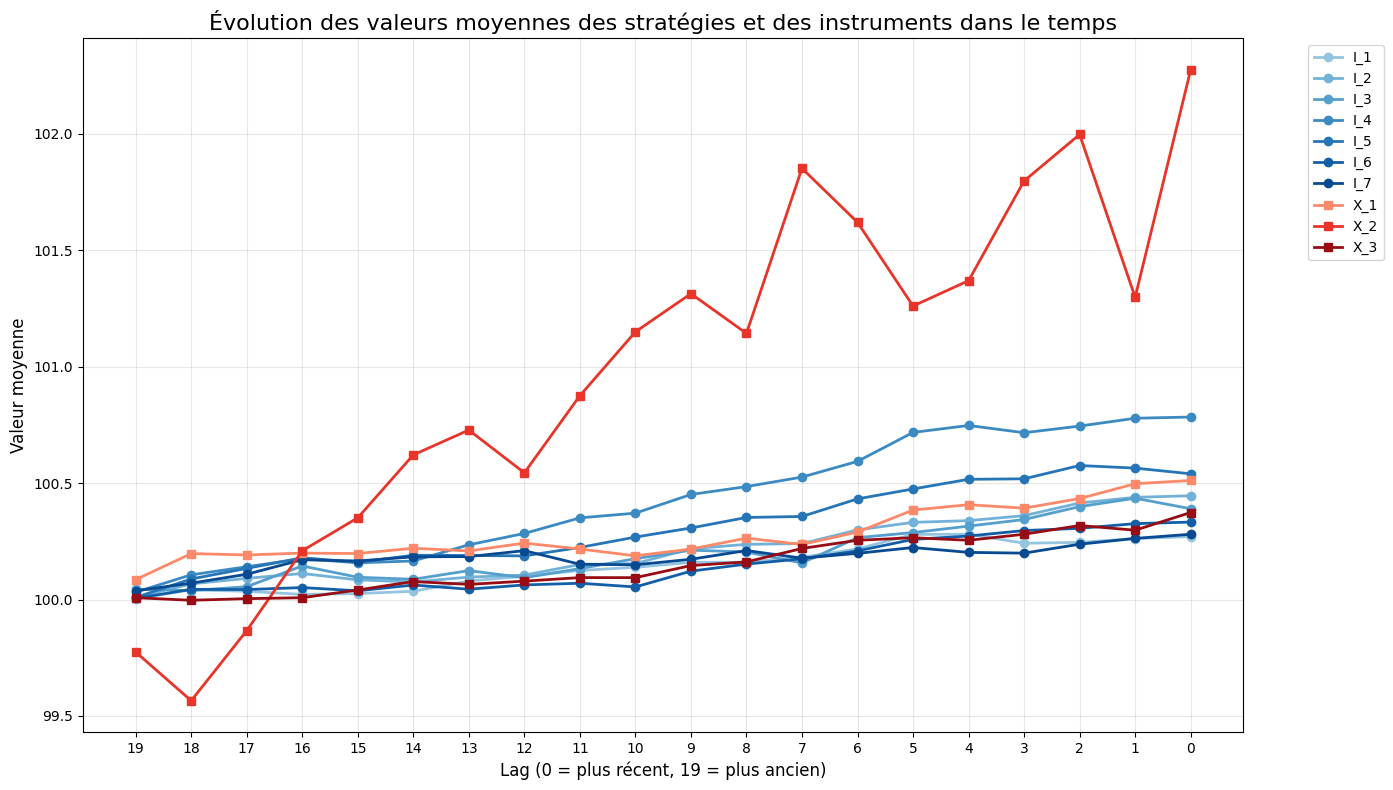

In [376]:
# Etape 2 : affichage
# Récupération des moyennes
means_by_element = extract_by_element_and_lag('mean', descriptive_features)

# On "inverse" les lags de sorte à ce que le graphique aille du plus ancien au plus récent
# 20 (données les plus anciennes) devient 0 par exemple
max_lag = means_by_element['lag'].max()
means_by_element['time'] = max_lag - means_by_element['lag']

# Eléments à visualiser
I_elements = [f'I_{i}' for i in range(1, 8)]
X_elements = [f'X_{i}' for i in range(1, 4)]

# Filtrage
filtered_means = means_by_element[means_by_element['element'].isin(I_elements + X_elements)]

# Création des graphiques et affichage
fig_means = create_line_chart(
    filtered_means,
    'mean',
    I_elements,
    X_elements,
    'Évolution des valeurs moyennes des stratégies et des instruments dans le temps',
    'Valeur moyenne'
)

plt.figure(fig_means.number)
plt.show()


On observe globalement des comportements fidèles à ceux attendus : les portefeuilles alloués aux différentes stratégies (I_1 à I_7) s'apprécient, de même que les valeurs des instruments (X_1 à X_3) qui sont inconnus. Cela témoigne d'une bonne performance des stratégies, tandis que l'interprétation des instruments est plus ardue, ceux-ci n'étant pas connus. L'instrument 2 (X_2) ressort évidemment, il offre un rendement sur 20 jours plus important en moyenne et semble plus volatile. Ces éléments nous confirment la nécessité de standardiser nos données afin d'équilibrer leur l'influence et d'éviter que des variables à forte dispersion ne dominent les algorithmes sensibles à l'échelle.

#### 2.3.2. Etudes descriptives de la variable cible



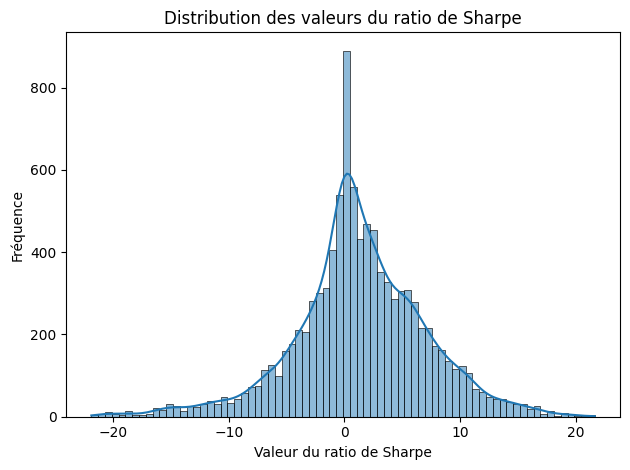

Skewness de la distribution des ratios de Sharpe : -0.26373135791649505
Excès de kurtosis de la distribution des ratios de Sharpe : 1.2519305744791578
===== Statistiques descriptives =====
count    9933.000000
mean        1.293375
std         5.806981
min       -21.902900
25%        -1.564104
50%         0.992727
75%         4.794639
max        21.665272
Name: Target, dtype: float64


In [377]:
# Histogramme
sns.histplot(labels["Target"], kde=True)
plt.xlabel("Valeur du ratio de Sharpe")
plt.ylabel("Fréquence")
plt.title('Distribution des valeurs du ratio de Sharpe')

plt.tight_layout()
plt.show()

# Skewness et kurtosis de la distribution des ratios de Sharpe
print(f"Skewness de la distribution des ratios de Sharpe : {labels['Target'].skew()}")
print(f"Excès de kurtosis de la distribution des ratios de Sharpe : {labels['Target'].kurt()}")

print("===== Statistiques descriptives =====")
print(labels["Target"].describe())

Ce graphique et ces valeurs nous permettent de faire plusieurs commentaires :
- La distribution des ratios de Sharpe est relativement symétrique mais légèrement décalée à gauche (skewness négatif),
- La distribution des ratios de Sharpe est leptokurtique, avec des queues de distribution plus épaisses qu'une distribution gaussienne. Cela est cohérent avec les faits stylisés des rendements financiers, qui ne suivent pas une distribution Normale.

Les ensembles de stratégies présentent un ratio de Sharpe annualisé moyen d'environ 1.3, ce qui se situe dans la tranche haute des valeurs usuelles des ratios de Sharpe. Cependant, l'élement le plus frappant reste la plage d'évolution de ce ratio, avec une étendue de plus de 40. On est donc face à des stratégies qui, certes, affichent de bonnes performances en moyenne, mais sont aussi très risquées. Cela se confirme par la volatilité du ratio de Sharpe. Rappelons d'ailleurs que nous avons nettoyé nos données : les résultats sont encore plus frappants sur les données non nettoyées. Le groupe Napoléon est spécialisé dans les stratégies utilisant des cryptomonnaies, ce qui explique de telles statistiques.   

#### 2.3.3. Corrélation entre les features

Intéressons-nous aux corrélations entre les features, des corrélations trop fortes entre les *features* (ou, comme nous raisonnons aussi avec des séries temporelles, des cas d'autocorrélation) peut réduire l'interprétabilité (difficile d'isoler l'effet individuel de chaque feature sur la prévision) et la performance du modèle (certains algorithmes sont sensibles à la multicolinéarité). En outre, cela peut aussi favoriser l'overfitting. Nous en profitons pour suprimer la colonne "lag_20" (identiques pour tout l'échantillon).

In [378]:
# Copies de sécurité
features_clean = features.copy()
labels_clean = labels.copy()


La représentation de la matrice de corrélation n'est pas simple étant donnée sa taille. Nous proposons deux approches :
- une approche par heatmap usuelle sur la partie triangulaire inférieure de la matrice. C'est une solution peu fine, mais elle permet de voir à vue d'oeil si les corrélations sont **globalement** fortes ou faibles entre les features ;
- un affichage de l'histogramme des corrélations. Si l'on s'aperçoit qu'un nombre conséquent de corrélations sont élevées, nous investiguerons davantage.
Nous procédons également au test de significativité des corrélations :
\begin{align*}
H_0 &: \rho_{X,Y} = 0 \\
H_1 &: \rho_{X,Y} \neq 0
\end{align*}

Avec $n$ le nombre d'observation, la statistique de test associée s'énonce :
\begin{align*}
t = \hat{\rho_{X,Y}} \times \sqrt{\frac{n-2}{1-\hat{\rho_{X,Y}}^2}} \sim St(n-2)
\end{align*}
Si la pvalue calculée est inférieure à 5% (seuil de risque de première espèce retenu), on rejette $H_0$. La fonction suivante traduit en code les éléments sus-mentionnés et permet de fournir l'analyse globale des corrélations de Pearson.

In [379]:
def pearson_pvalue(r: float, n: int) -> float:
        """
        Calcule la p-value pour un coefficient de corrélation de Pearson donné
        Inputs :
        ---------
        r : coefficient de corrélation
        n : nombre de samples / observations
        """
        if abs(r) == 1.0:
            return 0.0
        t = r * np.sqrt((n-2) / (1-r**2))
        p = 2 * (1 - stats.t.cdf(abs(t), n-2))
        return p

def analyze_correlations(df: pd.DataFrame,
                         alpha: float=0.05) -> Tuple[pd.DataFrame, float]:
    """
    Analyse complète des corrélations d'un ensemble de données :
    - Matrice de corrélation
    - Distribution des coefficients de corrélation
    - Test de significativité des corrélations et distribution des p-values
    La corrélation de Pearson est utilisée et le nombre de données est suffisamment grand pour que
    les hypothèses de normalité soient supposées (théorème central limite)
    Inputs :
        df : DataFrame à analyser
        alpha : Seuil de significativité, par défaut 0.05
    Outputs :
        Tuple contenant la matrice de corrélation et le pourcentage de corrélations significatives
    """
    # 1. Setup
    ## Matrice de corrélation
    corr_matrix = df.corr(method='pearson')

    ## Création du masque pour le triangle inférieur de la matrice de corrélation
    mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    mask_lower = np.tril(np.ones_like(corr_matrix, dtype=bool), k=-1)

    ## 2. Affichage de la matrice de corrélation
    plt.figure(figsize=(15,12))
    sns.heatmap(corr_matrix, mask=mask_upper, cmap="coolwarm",
                annot=False, linewidths=0.5, vmin=-1, vmax=1)
    plt.title("Matrice de Corrélation (Triangle Inférieur)", fontsize=16)
    plt.tight_layout()
    plt.show()

    # 3. Affichage de la distribution des coefficients de corrélation
    corr_values = corr_matrix.values[mask_lower]
    plt.figure(figsize=(10,6))
    sns.histplot(corr_values, bins=50, kde=True, color="royalblue")
    plt.xlabel("Coefficient de corrélation", fontsize=12)
    plt.ylabel("Fréquence", fontsize=12)
    plt.title("Distribution des coefficients de corrélation", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 4. Test de significativité des corrélation et distribution des p-values
    n = len(df)

    ## Calcul des p-values pour chaque coefficient
    pvalues = np.array([pearson_pvalue(r, n) for r in corr_values])

    ## Affichage de la distribution des p-values
    plt.figure(figsize=(10,6))
    plt.hist(pvalues, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(x=alpha, color='red', linestyle='--',
                label=f'Seuil de significativité (p={alpha})')
    plt.title('Distribution des p-values des coefficients de corrélation', fontsize=14)
    plt.xlabel('p-value', fontsize=12)
    plt.ylabel('Fréquence', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    ## Statistiques sur les p-values
    significant_count = np.sum(pvalues < alpha)
    total_count = len(pvalues)
    significant_percent = significant_count / total_count * 100

    print(f"Nombre de corrélations testées : {total_count}")
    print(f"Nombre de corrélations significatives (p < {alpha}) : {significant_count}")
    print(f"Pourcentage de corrélations significatives : {significant_percent:.2f}%")

    return corr_matrix, significant_percent

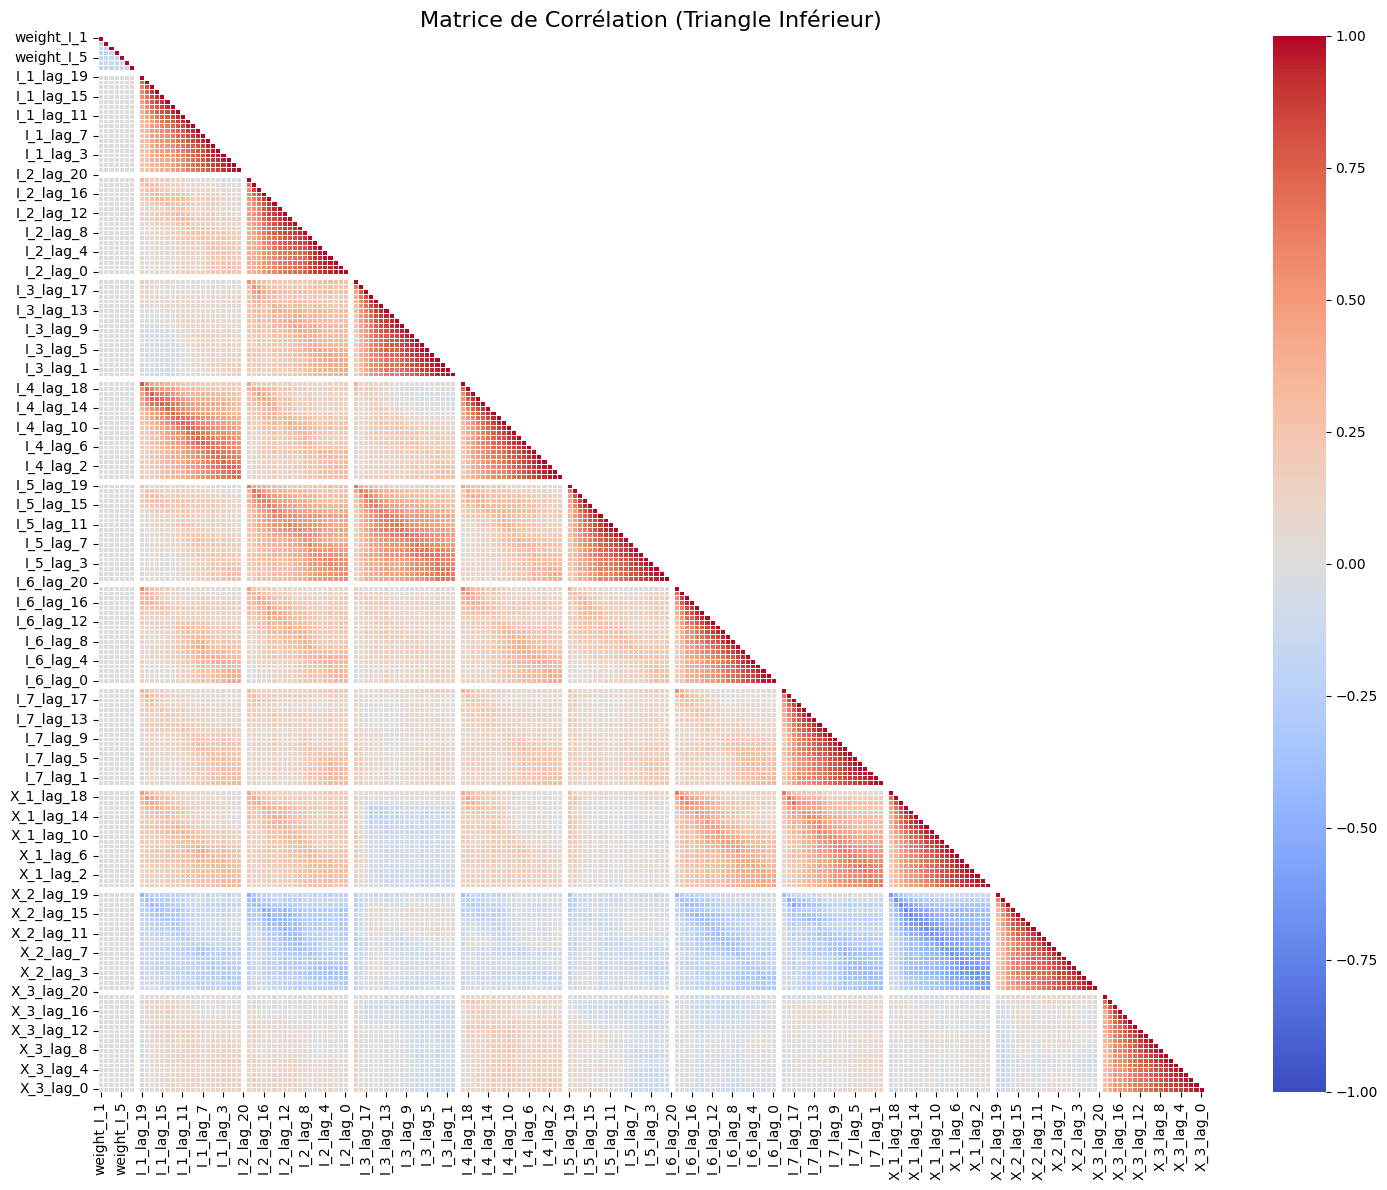

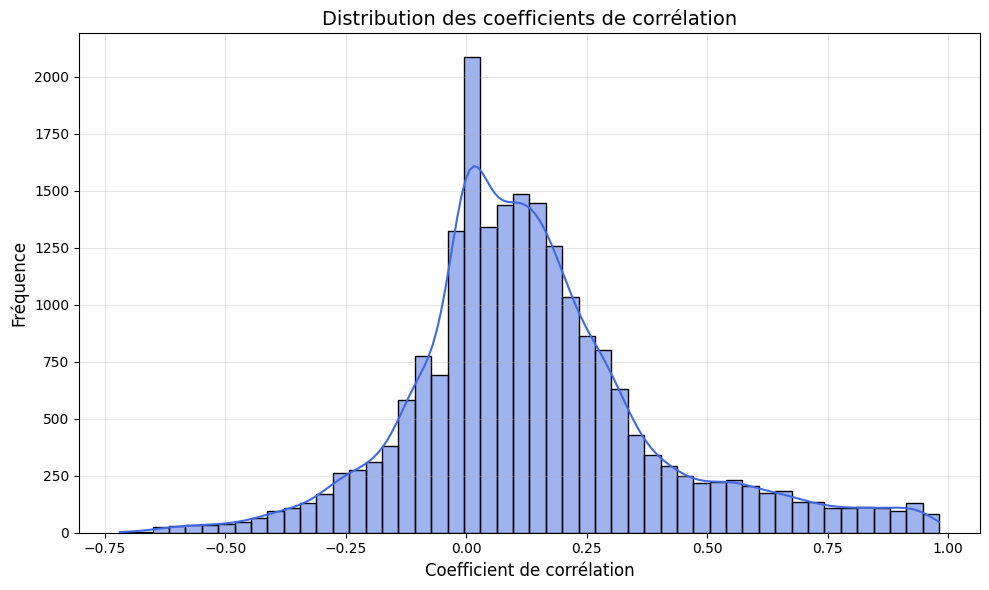

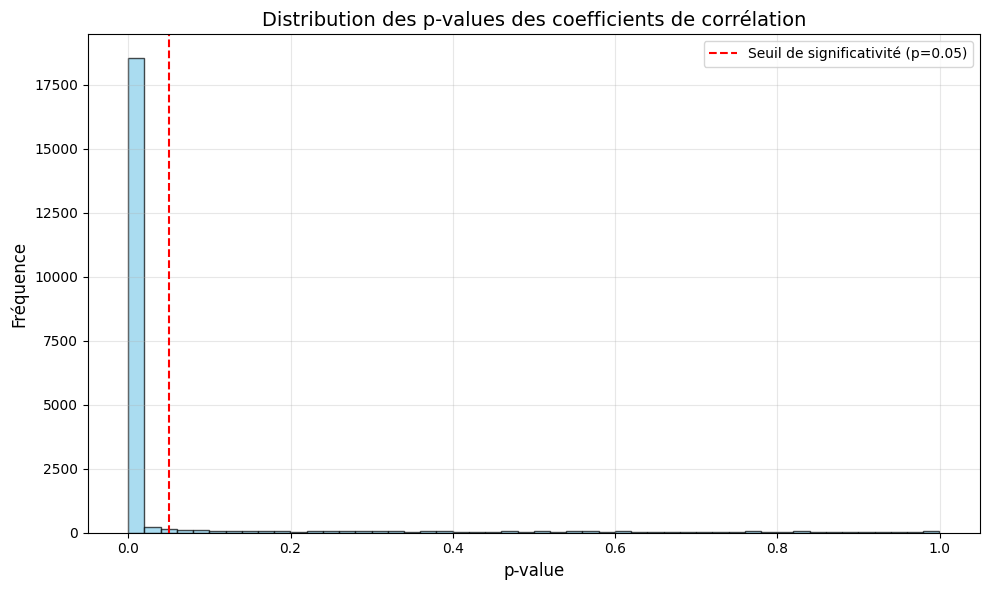

Nombre de corrélations testées : 23436
Nombre de corrélations significatives (p < 0.05) : 18833
Pourcentage de corrélations significatives : 80.36%


In [380]:
corr_matrix, significant_percent = analyze_correlations(
    df=features_clean,
    alpha=0.05
)

De ces graphiques, nous pouvons faire deux principales remarques :
- d'un côté, les séries temporelles des valeurs des stratégies ne semblent pas fortement corrélées entre elles, ni avec les poids (zones bleuâtres/grises sur la matrice de corrélation), ni avec les instruments financiers. Cela est positif, puisque cela suggère ces variables n'expliquent pas les mêmes éléments.
- d'un autre côté, de fortes corrélations positives existent au sein des séries temporelles. Cela reflète très probablement la présence d'autocorrélation dans les séries de prix, ce qui est un phénomène connu des marchés. La différenciation permet généralement d'aboutir à des séries stationnaires non autocorrélées. Nous reviendrons plus en détail sur ces points dans la suite.
- on observe que plus de 80% des variables ont une corrélation significative. Un traitement est donc nécessaire pour augmenter le champ d'information expliqué par les variables.

#### 2.3.4. Calcul des rendements

Les features que nous avons à notre disposition contiennent des séries de prix sur 21 jours. Le label final étant le ratio de Sharpe, calculé à partir des rendements des stratégies, nous allons transformer nos séries de prix en rendements (logarithmiques). Cette méthode devrait en outre permettre de **réduire, voire supprimer, l'autocorrélation** dans nos séries temporelles. Les rendements logarithmiques sont utilisés dans le calcul du ratio de Sharpe, ce sont donc ceux que nous utiliserons ici.

In [381]:
def compute_returns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Fonction qui procède au calcul des rendements des stratégies et instruments financiers.

    Inputs :
    ----------
    df : DataFrame contenant les features initiaux

    Outputs :
    ----------
    DataFrame avec les poids, suivis des rendements
    """
    # 7 premières colonnes : poids
    rdt = df.iloc[:, :7].copy()

    # Calcul des rendements
    columns_value_strategies = df.columns[7:]
    for i in range(len(columns_value_strategies) - 1):
        current_prices = columns_value_strategies[i]
        next_prices = columns_value_strategies[i + 1]
        col_names = f"rendement_{df.columns[i+8]}"  # cela permet d'avoir
        # des colonnes nommées "rendement_I_lag_19" pour le rendement le plus ancien (le plus proche = lag_0)
        rdt[col_names] = np.log(df[next_prices] / df[current_prices])

    return rdt

# Dataframe avec poids et rendements
features_rdt = compute_returns(features_clean)
cols_rdt_20 = [col for col in features_rdt.columns if "lag_20" in col]
# On retire les colonnes "lag_20" car elles sont le résultat du calcul ln(X_i_lag_0/ X_j_lag_20)
features_rdt = features_rdt.drop(columns=cols_rdt_20)
display(features_rdt.head(5))


,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,rendement_I_1_lag_19,rendement_I_1_lag_18,rendement_I_1_lag_17,...,rendement_X_3_lag_9,rendement_X_3_lag_8,rendement_X_3_lag_7,rendement_X_3_lag_6,rendement_X_3_lag_5,rendement_X_3_lag_4,rendement_X_3_lag_3,rendement_X_3_lag_2,rendement_X_3_lag_1,rendement_X_3_lag_0
ID,,,,,,,,,,,,,,,,,,,,,
0,0.15,0.00,0.05,0.80,0.00,0.0,0.00,0.000474,0.000111,-0.000109,...,0.003170,0.006595,0.003140,0.007522,0.000000,-0.000991,0.000283,0.000566,0.000848,0.001130
1,0.00,0.00,0.00,0.40,0.25,0.0,0.35,-0.000877,0.000482,0.002222,...,0.006313,0.000273,0.000547,0.001366,-0.003829,-0.002195,-0.002200,-0.000276,0.000276,0.002497
2,0.85,0.00,0.00,0.15,0.00,0.0,0.00,-0.005197,0.007191,0.002078,...,-0.001336,0.002076,-0.002670,0.004741,0.002215,-0.003250,0.000000,-0.006235,-0.003132,0.002238
3,0.00,0.00,0.70,0.05,0.25,0.0,0.00,0.001245,-0.001012,0.002725,...,0.001197,0.001941,0.000149,0.005059,0.001335,0.002664,-0.002368,0.001037,0.002365,-0.003846
4,0.00,0.55,0.05,0.00,0.00,0.0,0.40,0.000000,-0.005940,0.000109,...,0.005515,-0.001835,0.001224,0.004271,-0.001828,0.005777,0.000000,0.003935,0.000905,-0.000604


#### 2.3.5. Feature engineering

Nous cherchons à créer un certain nombre de features afin de capturer des dynamiques sous-jacentes plus complexes, qui nous permettront ensuite d'entraîner notre modèle. En plus des rendements journaliers, nous proposons les features suivants :
- covariances entre les rendements des stratégies, entre les rendements des indicateurs économiques et entre les rendements stratégies et les rendements indicateurs économiques (afin d'identifier d'éventuelles relations structurelles entre variables),
- volatilités des rendements (mesure de risque au dénominateur du ratio de Sharpe),
- ratios de Sharpe hebdomadaires (pour capturer une potentielle autocorrélation dans le ratio de Sharpe);
- skewness et kurtosis des rendements (permet de distinguer des stratégies dont la performance repose sur des événements extrêmes de celles qui performent régulièrement. Par exemple, deux stratégies peuvent avoir le même ratio de Sharpe, mais l'une présente une distribution des rendements leptokurtique asymétrique à gauche et donc avec des drawdowns potentiellement larges et réguliers, l'autre symétrique avec faible kurtosis),
- l'indice Herfindahl-Hirschman (HHI) comme mesure de la diversification (permet de voir si le ratio de Sharpe est meilleur lorsque l'AUM est alloué de manière diversifié ou non) :
$$
HHI = \sum_{i=1}^N \omega_i^2, \quad 0 < HHI \leq 1 \\
\begin{cases}
HHI = 1 : \text{ portefeuille totalement concentré} \\
HHI = \frac{1}{N} : \text{ portefeuille équipondéré}
\end{cases}
$$

In [382]:
def feature_engineering(df: pd.DataFrame, weights: Optional[pd.DataFrame]=None,
                        nb_strat: int=7, nb_indic: int=3, nb_days: int=20) -> pd.DataFrame:
    """
    Fonction qui calcule toutes les features :
    - Covariances entre stratégies, indicateurs, et entre les stratégies et les indicateurs
    - Volatilités des stratégies et indicateurs
    - Skewness et kurtosis
    - Ratio de Sharpe personnalisé (si weights est fourni)
    - HHI

    Inputs :
    -----------
        df: DataFrame contenant les rendements
        weights : DataFrame ou array contenant les poids (optionnel)
        nb_strat: Nombre de stratégies (7 par défaut)
        nb_indic: Nombre d'indicateurs (3 par défaut)
        nb_days: Nombre de jours de rendements (20 par défaut)

    Output :
    -----------
        DataFrame contenant toutes les features calculées pour chaque observation.
    """
    nb_rows = df.shape[0]

    # Création de paires et de noms de colonnes
    # On récupère les nb_strat * nb_days premières colonnes pour les rendements des stratégies,
    # et le reste pour les rendements des indicateurs
    strat_cols = df.columns[:nb_strat * nb_days].tolist()
    indic_cols = df.columns[nb_strat * nb_days:(nb_strat + nb_indic) * nb_days].tolist()

    # 1. Définition des colonnes pour les covariances
    strat_pairs = list(combinations(range(1, nb_strat+1), 2))
    strat_strat_cols = [f'cov_I_{i}_I_{j}' for i, j in strat_pairs]

    indicator_pairs = list(combinations(range(1, nb_indic+1), 2))
    indic_indic_columns = [f'cov_X_{i}_X_{j}' for i, j in indicator_pairs]

    strat_indic_pairs = [(i, j) for i in range(1, nb_strat+1) for j in range(1, nb_indic+1)]
    strat_indic_columns = [f'cov_I_{i}_X_{j}' for i, j in strat_indic_pairs]

    # 2. Définition des colonnes pour les volatilités
    vol_columns = [f'vol_I_{s}' for s in range(1, nb_strat+1)] + [f'vol_X_{i}' for i in range(1, nb_indic+1)]

    # 3. Définition des colonnes pour le skewness et kurtosis
    skew_columns = [f'skew_I_{s}' for s in range(1, nb_strat+1)] + [f'skew_X_{i}' for i in range(1, nb_indic+1)]
    kurt_columns = [f'kurt_I_{s}' for s in range(1, nb_strat+1)] + [f'kurt_X_{i}' for i in range(1, nb_indic+1)]

    # 4. Colonnes pour le ratio de Sharpe et HHI (si weights fourni)
    nb_weeks = nb_days // 5
    sharpe_columns = [f'sharpe_week_{w+1}' for w in range(nb_weeks)] if weights is not None else []
    hhi_column = ['HHI'] if weights is not None else []

    # Combinaison de toutes les colonnes pour le tableau final
    all_columns = strat_strat_cols + indic_indic_columns + strat_indic_columns + \
        vol_columns + skew_columns + kurt_columns + sharpe_columns + hhi_column
    results = pd.DataFrame(np.nan, index=df.index, columns=all_columns, dtype=float)


    # On récupère les indices des colonnes pour chaque stratégie et indicateur
    strat_indices = {}
    indic_indices = {}

    for s in range(1, nb_strat+1):
        strat_cols_s = strat_cols[(s-1)*nb_days:s*nb_days]
        strat_indices[s] = [df.columns.get_loc(col) for col in strat_cols_s]

    for i in range(1, nb_indic+1):
        indic_cols_i = indic_cols[(i-1)*nb_days:i*nb_days]
        indic_indices[i] = [df.columns.get_loc(col) for col in indic_cols_i]


    for row_pos in range(nb_rows):
        idx = df.index[row_pos]              # index initial (à conserver)
        row_values = df.iloc[row_pos].values


        # Extraction des données pour chaque stratégie et indicateur
        strat_data = {}
        indic_data = {}

        for s in range(1, nb_strat+1):
            strat_data[s] = row_values[strat_indices[s]]

        for i in range(1, nb_indic+1):
            indic_data[i] = row_values[indic_indices[i]]

        ########## Calcul des covariances ##########

        for col_idx, (s1, s2) in enumerate(strat_pairs):
            cov = np.cov(strat_data[s1], strat_data[s2])[0, 1]
            results.loc[idx, strat_strat_cols[col_idx]] = cov

        # Entre indicateurs
        for col_idx, (i1, i2) in enumerate(indicator_pairs):
            cov = np.cov(indic_data[i1], indic_data[i2])[0, 1]
            results.loc[idx, indic_indic_columns[col_idx]] = cov

        # Entre stratégies et indicateurs
        for col_idx, (s, i) in enumerate(strat_indic_pairs):
            cov = np.cov(strat_data[s], indic_data[i])[0, 1]
            results.loc[idx, strat_indic_columns[col_idx]] = cov

        ########## Calcul des volatilités ##########
        for s in range(1, nb_strat+1):
            vol = np.std(strat_data[s], ddof=1)
            results.loc[idx, f'vol_I_{s}'] = vol

        for i in range(1, nb_indic+1):
            vol = np.std(indic_data[i], ddof=1)
            results.loc[idx, f'vol_X_{i}'] = vol

        ########## Calcul des skewness et kurtosis ##########
        for s in range(1, nb_strat+1):
            results.loc[idx, f'skew_I_{s}'] = stats.skew(strat_data[s])
            results.loc[idx, f'kurt_I_{s}'] = stats.kurtosis(strat_data[s], fisher=True)

        for i in range(1, nb_indic+1):
            results.loc[idx, f'skew_X_{i}'] = stats.skew(indic_data[i])
            results.loc[idx, f'kurt_X_{i}'] = stats.kurtosis(indic_data[i], fisher=True)

        ########## Calcul du HHI ##########
        if weights is not None:
            # On récupère les poids pour la ligne
            if isinstance(weights, pd.DataFrame):
                w = weights.loc[idx].values
            else:
                w = weights[row_pos]

            hhi = np.sum(w ** 2)    
            results.loc[idx, 'HHI'] = hhi

        ########## Calcul des ratios de Sharpe ##########
        if weights is not None:
            # Récupérer les poids pour cette ligne
            if isinstance(weights, pd.DataFrame):
                w = weights.loc[idx].values
            else:
                w = weights[row_pos]

            # Calcul pour chaque semaine
            for week in range(nb_weeks):
                # Indices pour la semaine
                start_idx = week * 5
                end_idx = start_idx + 5

                # Calcul du numérateur
                weekly_returns = np.zeros(nb_strat)
                # On calcule la somme des rendements pour chaque stratégie
                for s in range(1, nb_strat+1):
                    weekly_returns[s-1] = np.sum(strat_data[s][start_idx:end_idx])
                # Somme pondérée des rendements hebdomadaires + annualisation
                weighted_return = np.sum(w * weekly_returns) * (252 / 5)

                # Calcul du dénominateur
                # Matrice de covariance
                # Remarque : le calcul "manuel" est nécessaire car on considère les rendements d'un seul échantillon
                cov_matrix = np.zeros((nb_strat, nb_strat))

                for i in range(1, nb_strat+1):
                    for j in range(1, nb_strat+1):
                        # On récupère tous les rendements pour les stratégies i et j
                        returns_i = strat_data[i]
                        returns_j = strat_data[j]

                        # Moyennes des rendements
                        mean_i = np.mean(returns_i)
                        mean_j = np.mean(returns_j)

                        # Covariance
                        dev_i = returns_i - mean_i
                        dev_j = returns_j - mean_j
                        cov_ij = np.sum(dev_i * dev_j) / (len(returns_i) - 1)

                        cov_matrix[i-1, j-1] = cov_ij

                # Calcul de la variance du portefeuille pondéré
                portfolio_variance = np.dot(w.T, np.dot(cov_matrix, w))

                # Volatilité annualisée
                portfolio_volatility = np.sqrt(252 * portfolio_variance)

                # Seuil minimum de 0.005
                denominator = max(portfolio_volatility, 0.005)

                # Ratio de Sharpe
                sharpe_ratio = weighted_return / denominator
                results.loc[idx, f'sharpe_week_{week+1}'] = sharpe_ratio

    return results

def process_features(features_rdt: pd.DataFrame) -> pd.DataFrame:
    """
    Fonction qui permet de concaténer tous nos features :
        - ceux créés via la fonction ci-dessus,
        - les poids,
        - les rendements journaliers.

    Input :
        features_rdt : DataFrame contenant toutes les données

    Output :
        DataFrame contenant toutes les features
    """
    # Colonnes par type
    cols_strategies = [col for col in features_rdt.columns if "rendement_I" in col]
    cols_indicators = [col for col in features_rdt.columns if "X" in col]


    features_data = features_rdt[cols_strategies+cols_indicators]
    weight_columns = features_rdt.iloc[:,:7]

    # On calcule toutes les features
    new_features = feature_engineering(features_data, weight_columns)
    # On ajoute les rendements bruts aux features
    rendements_df = features_data
    # On ajoute les poids et les rendements
    new_features = pd.concat([weight_columns, rendements_df, new_features], axis=1)
    new_features = new_features.apply(pd.to_numeric, errors='coerce')
    # On vérifie les dimensions
    print(f"features_rdt: {features_rdt.shape}")
    print(f"new_features: {new_features.shape}")

    return new_features

In [383]:
features_total = process_features(features_rdt)
display(features_total.head(5))

features_rdt: (9933, 207)
new_features: (9933, 287)


,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,rendement_I_1_lag_19,rendement_I_1_lag_18,rendement_I_1_lag_17,...,kurt_I_6,kurt_I_7,kurt_X_1,kurt_X_2,kurt_X_3,sharpe_week_1,sharpe_week_2,sharpe_week_3,sharpe_week_4,HHI
ID,,,,,,,,,,,,,,,,,,,,,
0,0.15,0.00,0.05,0.80,0.00,0.0,0.00,0.000474,0.000111,-0.000109,...,3.811761,3.535207,-0.484368,-1.019894,1.764071,-1.925208,7.977686,-2.132942,-8.615628,0.665
1,0.00,0.00,0.00,0.40,0.25,0.0,0.35,-0.000877,0.000482,0.002222,...,6.990684,-0.476448,-0.476448,1.147579,-0.128676,6.285693,6.709467,0.803147,17.656251,0.345
2,0.85,0.00,0.00,0.15,0.00,0.0,0.00,-0.005197,0.007191,0.002078,...,2.673641,-0.034851,-0.034851,-0.130658,-0.902351,7.726733,-1.166057,9.987583,5.182329,0.745
3,0.00,0.00,0.70,0.05,0.25,0.0,0.00,0.001245,-0.001012,0.002725,...,3.672120,0.517233,0.517233,-0.909922,-0.772276,5.733866,6.685264,-7.017447,-1.944735,0.555
4,0.00,0.55,0.05,0.00,0.00,0.0,0.40,0.000000,-0.005940,0.000109,...,3.000790,-0.088999,-0.117941,-0.640775,0.913934,3.883034,-0.671889,3.744763,-4.886388,0.465


Après ces calculs, on constate que certaines colonnes affichent des valeurs vides (NaN). Plus précisément, on identifie qu'elles sont présentes dans les skewness et kurtosis des rendements calculés en $t-4$ et $t-6$. On décide de supprimer ces colonnes. En effet, le nombre conséquent de valeurs vides dans ces 4 colonnes rend difficile la justification d'un remplacement par une valeur. De plus, le nombre important de données à notre disposition devrait rendre marginal l'effet de ces suppressions.

In [384]:
#features_total = features_total.drop(["skew_I_6", "kurt_I_6", "skew_I_4", "kurt_I_4"], axis = 1)

In [385]:
pd.options.display.max_rows = None
print(f"Le fichier de données contient {features_total.isna().sum().sum()} données manquantes.")

Le fichier de données contient 4078 données manquantes.


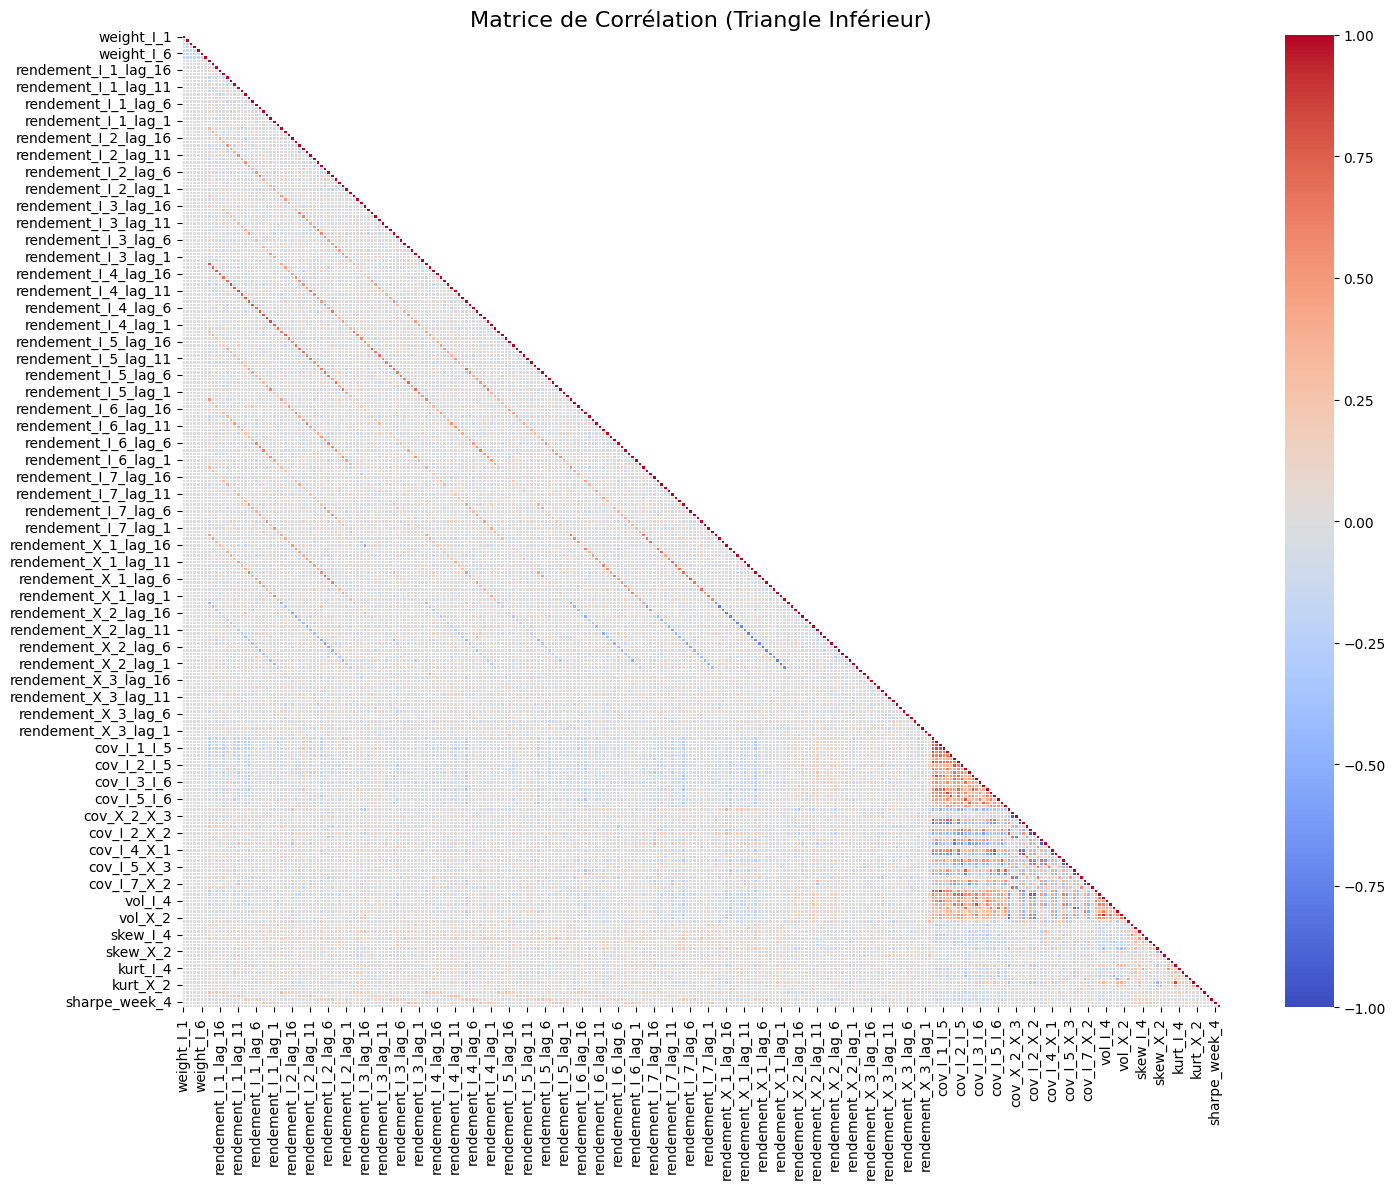

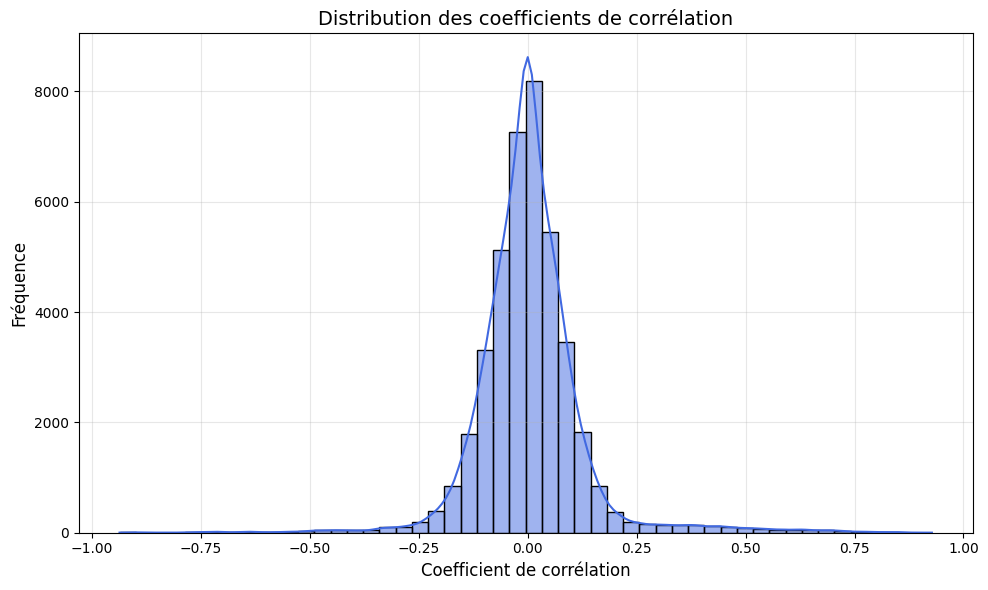

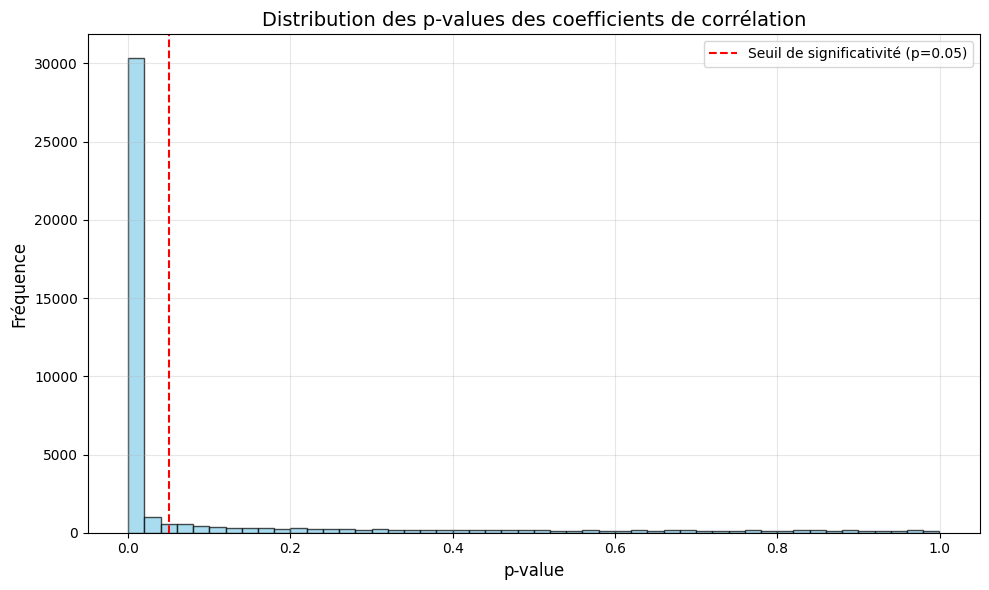

Nombre de corrélations testées : 41041
Nombre de corrélations significatives (p < 0.05) : 31694
Pourcentage de corrélations significatives : 77.23%


In [386]:
new_corr_matrix, new_significant_percent = analyze_correlations(features_total)

On constate que :
- La transformation des séries de prix en rendements logarithmiques a produit l'effet attendu (suppression de l'autocorrélation),
- les covariances présentent, quant à elles, des corrélations marquées : cela suggère l'existence d'une structure commune, latente, potentiellement exploitable par des techniques de réduction de la dimensionnalité comme les PCA.

### 2.4 Séparation du dataset

La division des données d’entraînement en jeux d’apprentissage et de validation est indispensable afin d’évaluer la capacité de généralisation du modèle. Dans notre cas, cette séparation requiert une attention particulière. En effet, notre dataset est construit à partir de fenêtres temporelles de 21 jours, chaque trajectoire de marché étant réutilisée jusqu’à 50 fois avec différentes combinaisons de poids appliquées aux stratégies. Deux observations distinctes peuvent ainsi correspondre à la même série temporelle sous-jacente, différant uniquement par leur pondération.

Afin d’éviter tout data leakage, il est donc impératif que deux observations partageant la même trajectoire de prix ne puissent jamais être réparties entre des ensembles d’apprentissage et de validation (ou de test). Autrement dit, toutes les “prises de vue” d’un même scénario de marché doivent être traitées comme une unité indivisible.

Pour répondre à cette contrainte, nous définissons des groupes d’observations à partir de la valeur finale d’une stratégie donnée (arbitrairement la deuxième, I_2_lag_0). Comme chaque stratégie est normalisée à 100 au début de chaque fenêtre, deux observations présentant exactement la même valeur finale pour cette stratégie correspondent nécessairement à la même trajectoire de 21 jours, indépendamment des poids appliqués. Ces observations sont donc regroupées sous un identifiant de groupe unique.

Dans un premier temps, nous procédons à une séparation explicite d’un jeu de test. Cette séparation est réalisée à l’aide de GroupShuffleSplit, qui sélectionne aléatoirement une fraction des groupes (20 % dans notre cas) pour constituer le jeu de test, tout en garantissant qu’aucun groupe n’est partagé entre les ensembles train/validation et test. Cette étape permet d’obtenir une évaluation finale totalement indépendante, réalisée sur des séries temporelles jamais observées durant la phase de sélection du modèle.

In [387]:

features_clean = features_clean.sort_index()
labels_clean = labels_clean.sort_index()

split_point = int(len(features_clean) * 0.80)


trainval_idx = features_clean.index[:split_point]
test_idx = features_clean.index[split_point:]

X_train = features_clean.loc[trainval_idx]
X_test = features_clean.loc[test_idx]

Y_train = labels_clean.loc[trainval_idx]["Target"]
Y_test = labels_clean.loc[test_idx]["Target"]

groups_trainval = np.arange(len(X_train))

print(f"Train : {min(trainval_idx)} -> {max(trainval_idx)} ({len(X_train)} samples)")
print(f"Test  : {min(test_idx)} -> {max(test_idx)} ({len(X_test)} samples)")
print(f"Y_train Shape: {Y_train.shape} (Doit être (8000,) et pas (8000,1))")

Train : 0 -> 7990 (7946 samples)
Test  : 7991 -> 9999 (1987 samples)
Y_train Shape: (7946,) (Doit être (8000,) et pas (8000,1))


La train set contient 7948 observations, et le test set en contient 1985. Nous procédons ensuite à la séparation en 5 folds du train set pour la validation croisée. 

In [388]:
print(Y_train.info())

<class 'pandas.core.series.Series'>
Index: 7946 entries, 0 to 7990
Series name: Target
Non-Null Count  Dtype  
--------------  -----  
7946 non-null   float64
dtypes: float64(1)
memory usage: 124.2 KB
None


In [389]:
Y_init = Y_train.copy()
"""
# --- IQR sur le TRAIN uniquement, en gardant Y_train comme DataFrame ---
y = Y_train["Target"]  # on lit la colonne, Y_train reste un DataFrame

Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 2 * IQR
upper = Q3 + 2 * IQR

mask = (y >= lower) & (y <= upper)   # Series bool indexée comme Y_train

print(f"Observations avant filtrage : {len(Y_train)}")
print(f"Observations après filtrage : {int(mask.sum())}")

# Filtrage (pas de leakage, et Y_train reste un DataFrame)
X_train = X_train.loc[mask]
Y_train = Y_train.loc[mask]

# groups_trainval est un array -> filtrage par position
groups_trainval = groups_trainval[mask.to_numpy()]"""

# Scorer sklearn basé sur la métrique spécifique au projet
napoleon_scorer = make_scorer(napoleon_metric, greater_is_better=False)

# Validation croisée groupée
cv = TimeSeriesSplit(n_splits=cfg.n_splits)

In [390]:
for k, (tr, va) in enumerate(cv.split(X_train, Y_train, groups_trainval)):
    gtr = set(groups_trainval[tr])
    gva = set(groups_trainval[va])
    inter = gtr.intersection(gva)
    print(k, "overlap groups:", len(inter))


0 overlap groups: 0
1 overlap groups: 0
2 overlap groups: 0
3 overlap groups: 0
4 overlap groups: 0


In [391]:
# print(Y_init.describe())
# print(Y_train.describe())

### 2.5 Prétraitement et fonctions utilitaires
Cette section regroupe les fonctions dédiées au prétraitement des données et à l’évaluation des modèles. Elles permettent de construire des pipelines de transformation (standardisation optionnelle) et d’implémenter une validation croisée respectant la structure des groupes. L’ensemble de ces fonctions est conçu pour garantir une évaluation sans data leakage, les opérations de prétraitement étant systématiquement ajustées sur les données d’entraînement de chaque fold.




Une fois le jeu de test isolé, nous appliquons une validation croisée groupée sur les données restantes. Pour cela, nous utilisons la méthode GroupKFold de scikit-learn, qui divise le jeu train/validation en $k$ folds en respectant strictement la structure des groupes. À chaque itération, certains groupes sont utilisés pour l’apprentissage tandis que les groupes restants servent à la validation. Cette procédure garantit qu’une trajectoire de marché donnée ne peut jamais apparaître simultanément dans les ensembles d’apprentissage et de validation, même sous des pondérations différentes.

La performance du modèle est évaluée sur chaque fold de validation, puis moyennée afin d’obtenir une estimation robuste de ses capacités de généralisation. Cette stratégie combinant séparation préalable du jeu de test et validation croisée groupée est essentielle pour prévenir tout data leakage dans un cadre où les observations présentent une forte redondance temporelle.

La fonction evaluate_cv_sklearn évalue un modèle par validation croisée groupée en entraînant l’estimateur sur chaque fold, en mesurant ses performances sur des groupes de données non vus, et en produisant à la fois des scores par fold et des prédictions out-of-fold.

In [392]:
def evaluate_cv_sklearn(estimator, X_feat, y, groups, cv, metric_fn, sample_weight=None):
    """
    Validation croisée groupée d'un estimateur sklearn.

    Inputs
    ------
    estimator : sklearn estimator ou Pipeline
        Modèle à entraîner et évaluer.
    X_feat : pandas.DataFrame
        Matrice des variables explicatives.
    y : pandas.Series ou array-like
        Variable cible.
    groups : array-like
        Identifiants de groupes utilisés pour la validation croisée
        (une valeur par observation).
    cv : objet de type GroupKFold
        Schéma de validation croisée groupée.
    metric_fn : callable
        Fonction de métrique prenant (y_true, y_pred) en entrée.

    Outputs
    -------
    dict
        Dictionnaire contenant :
        - mean : performance moyenne sur les folds,
        - std : écart-type des performances,
        - fold_scores : liste des scores par fold,
        - oof_pred : prédictions out-of-fold pour l'ensemble des observations.
    """
    # Stockage des scores de validation pour chaque fold
    fold_scores = []

    # Tableau des prédictions out-of-fold
    oof = np.zeros(len(y), dtype=float)

    for k, (tr, va) in enumerate(cv.split(X_feat, y, groups=groups), start=1):
        X_tr, y_tr = X_feat.iloc[tr], y.iloc[tr]
        X_va, y_va = X_feat.iloc[va], y.iloc[va]

        if sample_weight is not None:
             # On passe les poids filtrés pour le TRAIN set uniquement
             # On utilise 'model__sample_weight' car vous utilisez des Pipelines
             estimator.fit(X_tr, y_tr, model__sample_weight=sample_weight[tr])
        else:
             estimator.fit(X_tr, y_tr)
             
        pred = estimator.predict(X_va).reshape(-1)
        oof[va] = pred

        s = metric_fn(y_va.values, pred)
        fold_scores.append(s)
        print(f"Fold {k}: {s:.6f}")

    return {
        "mean": float(np.mean(fold_scores)),
        "std": float(np.std(fold_scores)),
        "fold_scores": fold_scores,
        "oof_pred": oof
    }

``make_preprocessor`` construit un pipeline de prétraitement qui applique une standardisation des variables explicatives lorsque cela est nécessaire. Il est utilisé en amont des modèles sensibles à l’échelle des données (comme les réseaux de neurones), tandis qu’il est désactivé pour les modèles invariants à l’échelle.

In [393]:
def make_preprocessor(scale: bool):
    steps = []
    if scale:
        steps.append(("scaler", StandardScaler()))
        return Pipeline(steps)
    return "passthrough"

``fit_selector_then_refit`` sélectionne automatiquement les variables et les hyperparamètres par validation croisée, puis entraîne un modèle final sur l’ensemble des données d’apprentissage restreint aux variables retenues.

In [394]:
def fit_selector_then_refit(pipe, param_dist, X_train, y_train, cv, scoring,
                            n_iter=40, random_state=42):
    """
    Sélection de variables et réglage des hyperparamètres par CV,
    suivis d'un ré-entraînement final sur l'ensemble du train.
    """
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        random_state=random_state,
        refit=True
    )
    search.fit(X_train, y_train)

    best_pipe = search.best_estimator_
    selector = best_pipe.named_steps["sel"]
    model = best_pipe.named_steps["model"]

    support = selector.get_support()
    X_train_sel = X_train[:, support]

    final_model = clone(model)
    final_model.fit(X_train_sel, y_train)

    return {
        "best_cv_score": search.best_score_,
        "best_params": search.best_params_,
        "best_pipe": best_pipe,
        "support": support,
        "final_model": final_model
    }

Ce bloc initialise les structures de stockage des résultats, définit la métrique d’évaluation compatible avec scikit-learn et met en place le schéma de validation croisée groupée utilisé pour comparer les modèles.

In [395]:
# Stockage des résultats de CV (détails par fold et résumé global)
results_folds = {}
results_summary = []


def store_eval(model, variant, eval_out):
    # Enregistrement des performances pour comparaison entre modèles
    results_folds[(model, variant)] = eval_out
    results_summary.append({
        "model": model,
        "variant": variant,
        "cv_mean": eval_out["mean"],
        "cv_std": eval_out["std"],
    })
    


Cette fonction effectue une recherche d’hyperparamètres par validation croisée groupée sur un pipeline intégrant une sélection de variables, puis retourne le meilleur modèle, les variables retenues et la performance associée.

In [396]:
def run_fs_pipeline(pipe, param_dist, X_feat, y, groups, cv, scorer, seed, n_iter, verbose=1,
                    selector_step="sel", model_step="model"):
    """
    Fit a pipeline (selector + model) with CV, using groups if provided.
    Returns search, best_estimator, best_score (same sign convention as your code).
    """
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=scorer,
        cv=cv,
        random_state=seed,
        n_jobs=-1,
        verbose=verbose,
        refit=True
    )
    search.fit(X_feat, y, groups=groups)

    best_pipe = search.best_estimator_
    best_score = float(-search.best_score_)   # comme toi

    support = best_pipe.named_steps[selector_step].get_support()

    return search, best_pipe, support, best_score


Nous calculons ici des poids exponentiels qui seront utilisés par TOUS les modèles (ElasticNet, RF, etc.) pour donner plus d'importance aux données récentes (2023-2024) qu'aux anciennes. Cela permet d'adapter le modèle à la baisse de volatilité du marché.

In [397]:
decay_rate = 0.0005
sample_weights = np.exp(-decay_rate * (len(Y_train) - 1 - np.arange(len(Y_train))))
sample_weights = sample_weights / sample_weights.mean()
print(f"Poids appliqués. Min: {sample_weights.min():.4f}, Max: {sample_weights.max():.4f}")

Poids appliqués. Min: 0.0762, Max: 4.0482


## 3. Validation croisée et sélection des modèles 

### 3.1 Benchmark

On observe un modèle de référence naïf qui prédit systématiquement la moyenne du label observée sur l’ensemble d’apprentissage, afin de disposer d’un point de comparaison minimal pour l’évaluation des modèles. 

In [398]:
print(Y_train.describe())

count    7946.000000
mean        1.266430
std         5.797977
min       -21.708823
25%        -1.528876
50%         0.956948
75%         4.729869
max        21.665272
Name: Target, dtype: float64


In [399]:
bench_const = float(Y_train.mean())
bench_pred = np.full_like(Y_test.values, bench_const, dtype=float)
bench_score = napoleon_metric(Y_test.values, bench_pred)

print("Benchmark const (train mean):", bench_const)  
print("Benchmark metric:", bench_score)


Benchmark const (train mean): 1.2664295808557784
Benchmark metric: 4.364416084413583


In [400]:
bench_const = float(Y_train.median())
bench_pred = np.full_like(Y_test.values, bench_const, dtype=float)
bench_score = napoleon_metric(Y_test.values, bench_pred)

print("Benchmark const (train mean):", bench_const)  
print("Benchmark metric:", bench_score)


Benchmark const (train mean): 0.9569483245128079
Benchmark metric: 4.367150877085833


In [401]:
c = float(Y_test.median())
pred = np.full_like(Y_test.values, c, dtype=float)
print("Best constant-on-test MAE:", napoleon_metric(Y_test.values, pred))


Best constant-on-test MAE: 4.363554844864763


In [402]:
print(Y_test.describe())

count    1987.000000
mean        1.401132
std         5.843075
min       -21.902900
25%        -1.672889
50%         1.168605
75%         4.939870
max        19.391387
Name: Target, dtype: float64


In [403]:
print(Y_train.median())
print(Y_train.mean())
print(Y_test.median())
print(Y_test.mean())

0.9569483245128079
1.2664295808557784
1.1686048659775692
1.4011320498957407


### 3.2 Elasticnet

#### 3.2.1 ElasticNet - baseline
Un modèle ElasticNet est optimisé par validation croisée groupée au sein d’un pipeline incluant la standardisation, puis évalué afin d’estimer de manière robuste ses performances.

In [418]:

enet = Pipeline([
    ("prep", StandardScaler()),
    ("model", ElasticNet(
        random_state=cfg.seed,
        max_iter=50_000,
        tol=1e-3,
        selection="random"
    ))
])

enet_space = {
    "model__alpha": np.logspace(-3, 0, 30),  
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
}

fit_params = {"model__sample_weight": sample_weights}

enet_search = RandomizedSearchCV(
    enet,
    param_distributions=enet_space,
    n_iter=cfg.n_iter_fast,
    scoring=napoleon_scorer,
    cv=cv,
    random_state=cfg.seed,
    n_jobs=-1,
    verbose=1,
    refit=True
)


print("Training ElasticNet Baseline...")
enet_search.fit(X_train, Y_train, groups=groups_trainval, **fit_params)

enet_best = enet_search.best_estimator_
enet_best_score = float(-enet_search.best_score_)

print("ElasticNet best (tune CV):", enet_best_score)
print("Best params:", enet_search.best_params_)

enet_eval = evaluate_cv_sklearn(enet_best, X_train, Y_train, groups_trainval, cv, napoleon_metric, sample_weight=sample_weights)
print("ElasticNet CV mean/std:", enet_eval["mean"], enet_eval["std"])

pred_test_enet = enet_best.predict(X_test)
score_enet = napoleon_metric(Y_test, pred_test_enet)
print(f"SCORE OOS (ElasticNet Base) : {score_enet:.4f}")

store_eval("elasticnet", "base", enet_eval)

Training ElasticNet Baseline...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
ElasticNet best (tune CV): 3.1192478900373857
Best params: {'model__l1_ratio': 0.7, 'model__alpha': np.float64(0.0020433597178569417)}
Fold 1: 3.252077
Fold 2: 3.214051
Fold 3: 3.088401
Fold 4: 2.949070
Fold 5: 3.092640
ElasticNet CV mean/std: 3.1192478900373857 0.10700595544896703
SCORE OOS (ElasticNet Base) : 3.0275


#### 3.2.2 ElasticNet - version avec sélection de variables

Un pipeline ElasticNet avec sélection de variables (via SelectFromModel) est optimisé par validation croisée groupée sur les hyperparamètres du sélecteur et du modèle, puis évalué afin d’estimer de manière robuste ses performances et de le comparer à la version sans sélection de variables.

In [417]:
enet_fs = Pipeline([
    ("prep", StandardScaler()),
    ("sel", SelectFromModel(
        ElasticNet(random_state=cfg.seed, max_iter=50_000, tol=1e-3, selection="random"),
        threshold="median"
    )),
    ("model", clone(enet_best.named_steps["model"]))
])


enet_fs_space = {
    "sel__estimator__alpha": np.logspace(-3, 0, 30),
    "sel__estimator__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
    "sel__threshold": ["mean", "median", 0.0],

    "model__alpha": np.logspace(-3, 0, 30),
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
}

# CORRECTION: On utilise sel__sample_weight
fit_params = {
    "model__sample_weight": sample_weights,
    "sel__sample_weight": sample_weights
}

enet_fs_search = RandomizedSearchCV(
    enet_fs,
    param_distributions=enet_fs_space,
    n_iter=cfg.n_iter_fast,
    scoring=napoleon_scorer,
    cv=cv,
    random_state=cfg.seed,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print("Training ElasticNet + FS avec Poids...")
enet_fs_search.fit(X_train, Y_train, groups=groups_trainval, **fit_params)

enet_fs_best = enet_fs_search.best_estimator_
enet_fs_best_score = float(-enet_fs_search.best_score_)

print("ElasticNet + FS best (tune CV):", enet_fs_best_score)
print("Best params:", enet_fs_search.best_params_)

enet_fs_eval = evaluate_cv_sklearn(
    enet_fs_best, X_train, Y_train, groups_trainval, cv, napoleon_metric, sample_weight=sample_weights
)
print("ElasticNet + FS CV mean/std:", enet_fs_eval["mean"], enet_fs_eval["std"])

pred_test_enet_fs = enet_fs_best.predict(X_test)
score_enet_fs = napoleon_metric(Y_test, pred_test_enet_fs)
print(f"SCORE OOS (ElasticNet + FS) : {score_enet_fs:.4f}")

store_eval("elasticnet", "fs", enet_fs_eval)

Training ElasticNet + FS avec Poids...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
ElasticNet + FS best (tune CV): 3.0930342846295096
Best params: {'sel__threshold': 0.0, 'sel__estimator__l1_ratio': 0.3, 'sel__estimator__alpha': np.float64(0.6210169418915616), 'model__l1_ratio': 0.3, 'model__alpha': np.float64(0.001)}
Fold 1: 3.230796
Fold 2: 3.188681
Fold 3: 3.060277
Fold 4: 2.925898
Fold 5: 3.059520
ElasticNet + FS CV mean/std: 3.0930342846295096 0.10794171675593787
SCORE OOS (ElasticNet + FS) : 2.9923


### 3.3 RandomForest 

#### 3.3.1 RandomForest - baseline
Le modèle Random Forest est entraîné avec pré-traitement, ses hyperparamètres sont optimisés par validation croisée, puis ses performances sont évaluées et enregistrées.

In [419]:
rf = Pipeline([
    ("prep", StandardScaler()), 
    ("model", RandomForestRegressor(random_state=cfg.seed, n_jobs=-1))
])
rf_space = {
    "model__n_estimators": [100, 300, 500],
    "model__max_depth": [6, 10, 15],
    "model__min_samples_leaf": [2, 5, 10],
    "model__max_features": ["sqrt", "log2"]
}
fit_params = {"model__sample_weight": sample_weights}
rf_search = RandomizedSearchCV(
    rf,
    param_distributions=rf_space,
    n_iter=cfg.n_iter_fast,
    scoring=napoleon_scorer,
    cv=cv,
    random_state=cfg.seed,
    n_jobs=-1,
    verbose=1,
    refit=True
)
rf_search.fit(X_train, Y_train, groups=groups_trainval, **fit_params)
rf_best = rf_search.best_estimator_
print("Best params:", rf_search.best_params_)
# Eval CV (Train)
rf_eval = evaluate_cv_sklearn(
    rf_best, X_train, Y_train, groups_trainval, cv, napoleon_metric, sample_weight=sample_weights
)
print("CV Mean:", rf_eval["mean"])
# TEST FINAL (OOS)
pred_test = rf_best.predict(X_test)
print("SCORE OOS (RF Base) :", napoleon_metric(Y_test.values, pred_test))
store_eval("rf", "base", rf_eval)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'model__n_estimators': 300, 'model__min_samples_leaf': 5, 'model__max_features': 'log2', 'model__max_depth': 15}
Fold 1: 2.917705
Fold 2: 2.815318
Fold 3: 2.669900
Fold 4: 2.470990
Fold 5: 2.395645
CV Mean: 2.653911713138442
SCORE OOS (RF Base) : 2.329302518571877


#### 3.3.2 RandomForest - version avec sélection de variables

Un pipeline RandomForest intégrant une sélection de variables par Lasso (via SelectFromModel) est mis en œuvre afin de filtrer le bruit et ne conserver que les signaux pertinents. Ce pipeline est optimisé par validation croisée groupée sur les hyperparamètres du sélecteur et du modèle, puis évalué afin d’estimer de manière robuste ses performances et de le comparer à la version sans sélection de variables

In [420]:
from sklearn.linear_model import Lasso
rf_fs = Pipeline([
    ("prep", StandardScaler()),
    ("sel", SelectFromModel(Lasso(random_state=cfg.seed), threshold="median")),
    ("model", RandomForestRegressor(random_state=cfg.seed, n_jobs=-1))
])
rf_fs_space = {
    "sel__estimator__alpha": [0.005, 0.01, 0.02, 0.05],
    "model__n_estimators": [100, 300, 600],
    "model__max_depth": [6, 10, 15],
    "model__min_samples_leaf": [2, 5, 10]
}
fit_params = {"model__sample_weight": sample_weights}
rf_fs_search = RandomizedSearchCV(
    rf_fs,
    param_distributions=rf_fs_space,
    n_iter=cfg.n_iter_fast,
    scoring=napoleon_scorer,
    cv=cv,
    random_state=cfg.seed,
    n_jobs=-1,    
    verbose=1,
    refit=True
)
rf_fs_search.fit(X_train, Y_train, groups=groups_trainval, **fit_params)
rf_fs_best = rf_fs_search.best_estimator_
print("Best params:", rf_fs_search.best_params_)

rf_fs_eval = evaluate_cv_sklearn(
    rf_fs_best, X_train, Y_train, groups_trainval, cv, napoleon_metric, sample_weight=sample_weights
)
print("CV Mean (Train):", rf_fs_eval["mean"])
pred_test_fs = rf_fs_best.predict(X_test)
print("SCORE OOS (RF + Lasso) :", napoleon_metric(Y_test.values, pred_test_fs))
store_eval("rf", "fs", rf_fs_eval)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'sel__estimator__alpha': 0.05, 'model__n_estimators': 600, 'model__min_samples_leaf': 2, 'model__max_depth': 15}
Fold 1: 2.528930
Fold 2: 2.190171
Fold 3: 2.117501
Fold 4: 1.817295
Fold 5: 1.794578
CV Mean (Train): 2.089695060536335
SCORE OOS (RF + Lasso) : 1.7331895233404762


### 3.4 XgBoost 

#### 3.4.1 XgBoost -  baseline

In [ ]:

xgb = Pipeline([
    ("prep", StandardScaler()),
    ("model", XGBRegressor(
        random_state=cfg.seed,
        tree_method="hist",
        objective="reg:squarederror",
        n_jobs=-1
    ))
])

xgb_space = {
    "model__max_depth": [2, 3, 4, 5],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__reg_alpha": [0.0, 1e-4, 1e-3, 1e-2],
    "model__reg_lambda": [0.5, 1.0, 2.0],
    "model__min_child_weight": [1, 3, 5],
    "model__n_estimators": [600, 1000, 1400],
}

fit_params = {"model__sample_weight": sample_weights}

xgb_search = RandomizedSearchCV(
    xgb,
    param_distributions=xgb_space,
    n_iter=cfg.n_iter_strong,
    scoring=napoleon_scorer,
    cv=cv,
    random_state=cfg.seed,
    n_jobs=-1,
    verbose=1,
    refit=True
)


print("Training XGBoost Baseline avec Poids...")
xgb_search.fit(X_train, Y_train, groups=groups_trainval, **fit_params)

xgb_best = xgb_search.best_estimator_
xgb_best_score = float(-xgb_search.best_score_)

print("XGB best (tune CV):", xgb_best_score)
print("Best params:", xgb_search.best_params_)

xgb_eval = evaluate_cv_sklearn(
    xgb_best, X_train, Y_train, groups_trainval, cv, napoleon_metric, sample_weight=sample_weights
)
print("XGB CV mean/std:", xgb_eval["mean"], xgb_eval["std"])

# Score OOS (Le Juge de Paix)
pred_test_xgb = xgb_best.predict(X_test)
score_xgb = napoleon_metric(Y_test, pred_test_xgb)
print(f"SCORE OOS (XGB Baseline) : {score_xgb:.4f}")

results_folds[("xgb", "base")] = xgb_eval
results_summary.append({"model": "xgb", "variant": "base",
                        "cv_mean": xgb_eval["mean"], "cv_std": xgb_eval["std"]})

store_eval("xgb", "base", xgb_eval)

Training XGBoost Baseline avec Poids...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGB best (tune CV): 1.9793574842627322
Best params: {'model__subsample': 0.8, 'model__reg_lambda': 2.0, 'model__reg_alpha': 0.01, 'model__n_estimators': 1400, 'model__min_child_weight': 3, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.6}
Fold 1: 2.530705
Fold 2: 2.065498
Fold 3: 1.874784
Fold 4: 1.746512
Fold 5: 1.679288
XGB CV mean/std: 1.9793574842627322 0.3054829606787925
SCORE OOS (XGB Baseline) : 1.6326


#### 3.4.2 XgBoost - version avec sélection de variables

In [415]:

xgb_selector = XGBRegressor(
    n_estimators=500,
    random_state=cfg.seed,
    tree_method="hist",
    n_jobs=-1
)

xgb_fs = Pipeline([
    ("prep", StandardScaler()),  
    ("sel", SelectFromModel(xgb_selector, threshold="median")),
    ("model", clone(xgb_best.named_steps["model"])) 
])

xgb_fs_space = {
    "sel__threshold": ["mean", "median", 0.001],
    "model__n_estimators": [300, 600, 900, 1200],
    "model__max_depth": [2, 3, 4, 6, 8],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__reg_alpha": [0.0, 1e-4, 1e-3, 1e-2, 1e-1],
    "model__reg_lambda": [0.5, 1.0, 2.0, 5.0, 10.0],
}


fit_params = {
    "model__sample_weight": sample_weights,
    "sel__estimator__sample_weight": sample_weights 
}


xgb_fs_search = RandomizedSearchCV(
    xgb_fs,
    param_distributions=xgb_fs_space,
    n_iter=cfg.n_iter_fast,
    scoring=napoleon_scorer,
    cv=cv,
    random_state=cfg.seed,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print("Training XGBoost + FS avec Poids...")

xgb_fs_search.fit(X_train, Y_train, groups=groups_trainval, model__sample_weight=sample_weights)

xgb_fs_best = xgb_fs_search.best_estimator_
xgb_fs_best_score = float(-xgb_fs_search.best_score_)

print("XGB + FS best (tune CV):", xgb_fs_best_score)
print("Best params:", xgb_fs_search.best_params_)

xgb_fs_eval = evaluate_cv_sklearn(
    xgb_fs_best, X_train, Y_train, groups_trainval, cv, napoleon_metric, sample_weight=sample_weights
)
print("XGB + FS CV mean/std:", xgb_fs_eval["mean"], xgb_fs_eval["std"])

pred_test_fs = xgb_fs_best.predict(X_test)
score_fs = napoleon_metric(Y_test, pred_test_fs)
print(f"SCORE OOS (XGB + FS) : {score_fs:.4f}")

results_folds[("xgb", "fs")] = xgb_fs_eval
results_summary.append({"model": "xgb", "variant": "fs",
                        "cv_mean": xgb_fs_eval["mean"], "cv_std": xgb_fs_eval["std"]})

store_eval("xgb", "fs", xgb_fs_eval)

Training XGBoost + FS avec Poids...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGB + FS best (tune CV): 2.3697940266941537
Best params: {'sel__threshold': 0.001, 'model__subsample': 1.0, 'model__reg_lambda': 0.5, 'model__reg_alpha': 0.1, 'model__n_estimators': 1200, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1.0}
Fold 1: 2.602595
Fold 2: 2.259986
Fold 3: 2.437277
Fold 4: 2.464265
Fold 5: 2.084847
XGB + FS CV mean/std: 2.3697940266941537 0.17940327982379825
SCORE OOS (XGB + FS) : 2.0308


#### 3.4.5 XGB lasso

In [421]:


xgb_fs_lasso = Pipeline([
    ("prep", StandardScaler()), 
    ("sel", SelectFromModel(Lasso(random_state=cfg.seed), threshold="median")),
    ("model", XGBRegressor(
        random_state=cfg.seed,
        tree_method="hist",
        objective="reg:absoluteerror",
        n_jobs=-1
    ))
])

xgb_fs_space = {
    "sel__estimator__alpha": [0.005, 0.01, 0.02, 0.05],
    "model__n_estimators": [300, 600, 900, 1200],
    "model__max_depth": [2, 3, 4, 6, 8],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "model__subsample": [0.6, 0.8, 1.0],
}

fit_params = {
    "model__sample_weight": sample_weights,
}

xgb_fs_search = RandomizedSearchCV(
    xgb_fs_lasso,
    param_distributions=xgb_fs_space,
    n_iter=cfg.n_iter_fast,
    scoring=napoleon_scorer,
    cv=cv,
    random_state=cfg.seed,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print("Training XGBoost + Lasso...")
xgb_fs_search.fit(X_train, Y_train, groups=groups_trainval, **fit_params)

xgb_fs_best = xgb_fs_search.best_estimator_
xgb_fs_best_score = float(-xgb_fs_search.best_score_)

print("XGB + Lasso best (tune CV):", xgb_fs_best_score)
print("Best params:", xgb_fs_search.best_params_)

xgb_fs_eval = evaluate_cv_sklearn(
    xgb_fs_best, X_train, Y_train, groups_trainval, cv, napoleon_metric, sample_weight=sample_weights
)
print("XGB + Lasso CV mean/std:", xgb_fs_eval["mean"], xgb_fs_eval["std"])

pred_test_xgb_fs = xgb_fs_best.predict(X_test)
score_xgb_fs = napoleon_metric(Y_test, pred_test_xgb_fs)
print(f"SCORE OOS (XGB + Lasso) : {score_xgb_fs:.4f}")

store_eval("xgb", "lasso", xgb_fs_eval)

Training XGBoost + Lasso...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGB + Lasso best (tune CV): 1.8348420927189308
Best params: {'sel__estimator__alpha': 0.05, 'model__subsample': 1.0, 'model__n_estimators': 300, 'model__max_depth': 8, 'model__learning_rate': 0.1}
Fold 1: 2.328691
Fold 2: 1.940248
Fold 3: 1.671180
Fold 4: 1.644519
Fold 5: 1.589573
XGB + Lasso CV mean/std: 1.8348420927189308 0.27501344453048654
SCORE OOS (XGB + Lasso) : 1.5864


### 3.5 MLP (Keras)

Cette partie implémente et évalue un réseau de neurones multicouche (MLP) sous TensorFlow/Keras dans un cadre de validation croisée : à chaque fold, les données sont imputées par la médiane et standardisées sur l’échantillon d’entraînement, le modèle est entraîné avec régularisation (L2, dropout) et arrêt anticipé, puis les prédictions hors-échantillon sont produites afin de calculer les performances par fold ainsi que leurs statistiques agrégées.

In [412]:
def build_mlp_tf(input_dim,
                 hidden_units=(128, 64),
                 dropout=0.2,
                 l2=1e-4,
                 lr=1e-3):
    inputs = keras.Input(shape=(input_dim,))
    x = inputs
    for u in hidden_units:
        x = layers.Dense(u, activation="relu",
                         kernel_regularizer=regularizers.l2(l2))(x)
        if dropout and dropout > 0:
            x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mae")
    return model


def fit_predict_one_fold_tf(X_tr, y_tr, X_va, cfg,
                            hidden_units, dropout, l2, lr, batch_size):
    # --- seed par fold pour stabilité ---
    tf.random.set_seed(cfg.seed)
    np.random.seed(cfg.seed)

    # preprocessing: fit sur train, apply sur val
    imputer = SimpleImputer(strategy="median")
    scaler = StandardScaler()

    X_tr_imp = imputer.fit_transform(X_tr)
    X_va_imp = imputer.transform(X_va)

    X_tr_sc = scaler.fit_transform(X_tr_imp).astype(np.float32)
    X_va_sc = scaler.transform(X_va_imp).astype(np.float32)

    y_tr = y_tr.astype(np.float32).reshape(-1, 1)

    model = build_mlp_tf(
        input_dim=X_tr_sc.shape[1],
        hidden_units=hidden_units,
        dropout=dropout,
        l2=l2,
        lr=lr
    )

    # EarlyStopping sur validation (plus "propre" que monitor=loss)
    cb = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=cfg.patience, restore_best_weights=True
    )

    model.fit(
        X_tr_sc, y_tr,
        validation_split=0.1,
        epochs=cfg.epochs,
        batch_size=batch_size,
        verbose=cfg.verbose_fit,
        callbacks=[cb]
    )

    pred = model.predict(X_va_sc, verbose=0).reshape(-1)
    return pred


def evaluate_cv_tf(X_feat, y, groups, cv, cfg, params, metric_fn):
    fold_scores = []
    oof = np.zeros(len(y), dtype=float)

    for k, (tr, va) in enumerate(cv.split(X_feat, y, groups=groups), start=1):
        X_tr = X_feat.iloc[tr].values
        y_tr = y.iloc[tr].values.astype(float)
        X_va = X_feat.iloc[va].values
        y_va = y.iloc[va].values.astype(float)

        pred = fit_predict_one_fold_tf(
            X_tr, y_tr, X_va, cfg,
            hidden_units=params["hidden_units"],
            dropout=params["dropout"],
            l2=params["l2"],
            lr=params["lr"],
            batch_size=params["batch_size"]
        )

        oof[va] = pred
        s = metric_fn(y_va, pred)
        fold_scores.append(s)
        print(f"Fold {k}: {s:.6f}")

    return {
        "mean": float(np.mean(fold_scores)),
        "std": float(np.std(fold_scores)),
        "fold_scores": fold_scores,
        "oof_pred": oof
    }


In [413]:
param_dist = {
    "hidden_units": [(64, 32), (128, 64), (256, 128)],
    "dropout": [0.0, 0.1, 0.2, 0.3],
    "l2": [1e-5, 1e-4, 1e-3],
    "lr": [1e-4, 3e-4, 1e-3],
    "batch_size": [64, 128, 256],
}

n_try = 10
candidates = list(ParameterSampler(param_dist, n_iter=n_try, random_state=cfg.seed))

best = {"params": None, "mean": np.inf, "std": None, "full": None}
trials = []

for i, params in enumerate(candidates, start=1):
    print(f"\n=== Trial {i}/{n_try} ===\n{params}")

    out = evaluate_cv_tf(X_train, Y_train, groups_trainval, cv, cfg, params, napoleon_metric)

    trials.append({"trial": i, "mean": out["mean"], "std": out["std"], **params})

    if out["mean"] < best["mean"]:
        best.update({"params": params, "mean": out["mean"], "std": out["std"], "full": out})
        print(f" New best: {best['mean']:.5f} (std {best['std']:.5f})")

print("\n BEST TF-MLP params:", best["params"])
print(" BEST TF-MLP mean :", best["mean"], " std:", best["std"])

trials_df = pd.DataFrame(trials).sort_values("mean").reset_index(drop=True)
display(trials_df.head(10))



=== Trial 1/10 ===
{'lr': 0.0001, 'l2': 0.001, 'hidden_units': (256, 128), 'dropout': 0.0, 'batch_size': 128}
Fold 1: 3.135564
Fold 2: 2.546815
Fold 3: 2.161157
Fold 4: 1.873671
Fold 5: 1.664718
 New best: 2.27639 (std 0.52171)

=== Trial 2/10 ===
{'lr': 0.0001, 'l2': 1e-05, 'hidden_units': (64, 32), 'dropout': 0.0, 'batch_size': 128}
Fold 1: 3.433397
Fold 2: 3.195180
Fold 3: 2.765605


KeyboardInterrupt: 

### 3.6 MLP avec sélection de variables

Cette partie entraîne un réseau de neurones multicouche (MLP) avec sélection de variables intégrée au fold : les données d’entraînement sont d’abord imputées et standardisées, puis les 
𝑘
k variables les plus informatives sont sélectionnées par un critère de dépendance (information mutuelle) estimé uniquement sur le train, avant d’entraîner le modèle TensorFlow et de produire des prédictions hors-échantillon sur le fold de validation.

In [ ]:
def fit_predict_one_fold_tf_fs(
    X_tr, y_tr, X_va, cfg,
    hidden_units, dropout, l2, lr, batch_size,
    k_best=50,
    score_func=mutual_info_regression,
):
    # 1) preprocess train-only
    imputer = SimpleImputer(strategy="median")
    scaler = StandardScaler()

    X_tr_imp = imputer.fit_transform(X_tr)
    X_va_imp = imputer.transform(X_va)

    X_tr_sc = scaler.fit_transform(X_tr_imp)
    X_va_sc = scaler.transform(X_va_imp)

    # 2) feature selection train-only
    sel = SelectKBest(score_func=score_func, k=k_best)
    X_tr_sel = sel.fit_transform(X_tr_sc, y_tr)
    X_va_sel = sel.transform(X_va_sc)

    # 3) fit TF model on selected features
    model = build_mlp_tf(
        input_dim=X_tr_sel.shape[1],
        hidden_units=hidden_units,
        dropout=dropout,
        l2=l2,
        lr=lr
    )

    cb = keras.callbacks.EarlyStopping(
        monitor="loss", patience=cfg.patience, restore_best_weights=True
    )

    model.fit(
        X_tr_sel, y_tr,
        epochs=cfg.epochs,
        batch_size=batch_size,
        verbose=cfg.verbose_fit,
        callbacks=[cb]
    )

    pred = model.predict(X_va_sel, verbose=0).reshape(-1)
    return pred


NameError: name 'mutual_info_regression' is not defined

In [ ]:
def evaluate_cv_tf_fs(X_feat, y, groups, cv, cfg, params):
    fold_scores = []
    oof = np.zeros(len(y), dtype=float)

    for k, (tr, va) in enumerate(cv.split(X_feat, y, groups=groups), start=1):
        X_tr = X_feat.iloc[tr].values
        y_tr = y.iloc[tr].values.astype(float)
        X_va = X_feat.iloc[va].values
        y_va = y.iloc[va].values.astype(float)

        pred = fit_predict_one_fold_tf_fs(
            X_tr, y_tr, X_va, cfg,
            hidden_units=params["hidden_units"],
            dropout=params["dropout"],
            l2=params["l2"],
            lr=params["lr"],
            batch_size=params["batch_size"],
            k_best=params["k_best"],
            score_func=params.get("score_func", mutual_info_regression),
        )

        oof[va] = pred
        s = napoleon_metric(y_va, pred)
        fold_scores.append(s)
        print(f"Fold {k}: {s:.6f}")

    return {
        "mean": float(np.mean(fold_scores)),
        "std": float(np.std(fold_scores)),
        "fold_scores": fold_scores,
        "oof_pred": oof
    }


In [ ]:
params_tf_fs = {
    "hidden_units": (128, 64),
    "dropout": 0.2,
    "l2": 1e-4,
    "lr": 1e-3,
    "batch_size": 256,
    "k_best": 50,   # <-- c’est ça la “best features” version MLP
    "score_func": mutual_info_regression
}

tf_mlp_fs_eval = evaluate_cv_tf_fs(X_train, Y_train, groups_trainval, cv, cfg, params_tf_fs)
print("TF MLP + FS CV mean/std:", tf_mlp_fs_eval["mean"], tf_mlp_fs_eval["std"])


Fold 1: 0.569218
Fold 2: 0.631884
Fold 3: 0.645534
Fold 4: 0.598659
Fold 5: 0.638902
TF MLP + FS CV mean/std: 0.6168396111575042 0.028756960876976784


### 3.7 MLP avec réduction de dimension (PCA)

Un modèle de type Multi-Layer Perceptron (MLP) est utilisé afin de capturer d’éventuelles relations non linéaires entre les poids des stratégies, les séries temporelles retardées et les indicateurs financiers.

Compte tenu de la forte dimensionnalité et des corrélations importantes entre variables, une réduction de dimension par Analyse en Composantes Principales (PCA) est appliquée après standardisation. La PCA est ajustée uniquement sur les données d’entraînement de chaque fold afin d’éviter toute fuite d’information.

L’évaluation est réalisée via une validation croisée GroupKFold, basée sur des fenêtres temporelles communes de 21 jours, et l’entraînement du réseau est régularisé par dropout, pénalisation L2 et early stopping.


In [ ]:
def build_mlp_tf(input_dim, hidden_units=(128, 64), dropout=0.2, l2=1e-4, lr=1e-3):
    inputs = keras.Input(shape=(input_dim,))
    x = inputs
    for u in hidden_units:
        x = layers.Dense(u, activation="relu", kernel_regularizer=regularizers.l2(l2))(x)
        if dropout and dropout > 0:
            x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mae")
    return model

def fit_transform_pca_on_train_only(X_train, X_val, pca_var=0.95, random_state=42):
    """Imputer+Scaler+PCA fit sur train, transform sur val."""
    imputer = SimpleImputer(strategy="median")
    scaler = StandardScaler()

    X_tr = scaler.fit_transform(imputer.fit_transform(X_train))
    X_va = scaler.transform(imputer.transform(X_val))

    pca = PCA(n_components=pca_var, svd_solver="full", random_state=random_state)
    X_tr_p = pca.fit_transform(X_tr)
    X_va_p = pca.transform(X_va)

    return X_tr_p, X_va_p, (imputer, scaler, pca)

def fit_predict_one_fold_tf_pca(X_tr, y_tr, X_va, cfg, params):
    # PCA preprocess (train only)
    X_tr_p, X_va_p, _ = fit_transform_pca_on_train_only(
        X_tr, X_va, pca_var=params["pca_var"], random_state=cfg.seed
    )

    # Repro (autant que possible)
    tf.random.set_seed(cfg.seed)

    model = build_mlp_tf(
        input_dim=X_tr_p.shape[1],
        hidden_units=params["hidden_units"],
        dropout=params["dropout"],
        l2=params["l2"],
        lr=params["lr"]
    )

    cb = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=cfg.patience, restore_best_weights=True
    )

    model.fit(
        X_tr_p, y_tr,
        validation_split=0.15,          # important pour early stopping
        epochs=cfg.epochs,
        batch_size=params["batch_size"],
        verbose=cfg.verbose_fit,
        callbacks=[cb]
    )

    pred = model.predict(X_va_p, verbose=0).reshape(-1)
    return pred


In [ ]:
def evaluate_cv_tf_pca(X_feat, y, groups, cv, cfg, params, metric_fn):
    fold_scores = []
    oof = np.zeros(len(y), dtype=float)

    for k, (tr, va) in enumerate(cv.split(X_feat, y, groups=groups), start=1):
        X_tr = X_feat.iloc[tr].values
        y_tr = y.iloc[tr].values.astype(float)
        X_va = X_feat.iloc[va].values
        y_va = y.iloc[va].values.astype(float)

        pred = fit_predict_one_fold_tf_pca(X_tr, y_tr, X_va, cfg, params)

        oof[va] = pred
        s = metric_fn(y_va, pred)
        fold_scores.append(s)
        print(f"Fold {k}: {s:.6f}")

    return {
        "mean": float(np.mean(fold_scores)),
        "std": float(np.std(fold_scores)),
        "fold_scores": fold_scores,
        "oof_pred": oof
    }


In [ ]:
simple_configs = [
    {"hidden_units": (64, 32),  "dropout": 0.2, "l2": 1e-4, "lr": 1e-3, "batch_size": 128, "pca_var": 0.95},
    {"hidden_units": (128, 64), "dropout": 0.2, "l2": 1e-4, "lr": 3e-4, "batch_size": 128, "pca_var": 0.95},
    {"hidden_units": (128, 64), "dropout": 0.1, "l2": 1e-5, "lr": 1e-3, "batch_size": 256, "pca_var": 0.90},
]

best_params_pca, best_score_pca, best_std_pca = None, np.inf, None
best_pca = {"params": None, "mean": np.inf, "std": None, "full": None}
for i, params in enumerate(simple_configs, start=1):
    print(f"\n=== TF-MLP+PCA Simple {i}/{len(simple_configs)} === {params}")
    out = evaluate_cv_tf_pca(X_train, Y_train, groups_trainval, cv, cfg, params, napoleon_metric)

    if out["mean"] < best_score_pca:
        best_pca.update({"params": params, "mean": out["mean"], "std": out["std"], "full": out})
        print("New best:", best_pca["mean"], "std:", best_pca["std"])

print("\nBEST TF-MLP+PCA:", best_pca["params"])
print("Score:", best_pca["mean"], "std:", best_pca["std"])




=== TF-MLP+PCA Simple 1/3 === {'hidden_units': (64, 32), 'dropout': 0.2, 'l2': 0.0001, 'lr': 0.001, 'batch_size': 128, 'pca_var': 0.95}
Fold 1: 0.564001
Fold 2: 0.611592
Fold 3: 0.670088
Fold 4: 0.585932
Fold 5: 0.588004
✅ New best: 0.603923172055785 std: 0.03635240440646441

=== TF-MLP+PCA Simple 2/3 === {'hidden_units': (128, 64), 'dropout': 0.2, 'l2': 0.0001, 'lr': 0.0003, 'batch_size': 128, 'pca_var': 0.95}
Fold 1: 0.594332
Fold 2: 0.603457
Fold 3: 0.655303
Fold 4: 0.615666
Fold 5: 0.638110
✅ New best: 0.6213736227166841 std: 0.02243274754006397

=== TF-MLP+PCA Simple 3/3 === {'hidden_units': (128, 64), 'dropout': 0.1, 'l2': 1e-05, 'lr': 0.001, 'batch_size': 256, 'pca_var': 0.9}
Fold 1: 0.599480
Fold 2: 0.617535
Fold 3: 0.681326
Fold 4: 0.605451
Fold 5: 0.636853
✅ New best: 0.6281290597010798 std: 0.029507192592925554

BEST TF-MLP+PCA: {'hidden_units': (128, 64), 'dropout': 0.1, 'l2': 1e-05, 'lr': 0.001, 'batch_size': 256, 'pca_var': 0.9}
Score: 0.6281290597010798 std: 0.029507192


Les différentes configurations testées du MLP avec PCA obtiennent des scores de validation croisée compris entre 0.67 et 0.69, avec une variabilité non négligeable selon les folds.

La réduction de dimension améliore la stabilité de l’entraînement, mais ne permet pas au MLP de surpasser les modèles basés sur les arbres, qui restent plus performants et plus robustes dans ce contexte.

En conséquence, le MLP est conservé comme modèle de référence non linéaire, mais n’est pas retenu comme approche principale pour la suite de l’analyse.


## 4. Prédiction sur le test set et résultats


Cette section vise à analyser et interpréter les performances obtenues par les différents modèles testés, au-delà de la seule comparaison numérique des scores. L’objectif est d’identifier les tendances générales, de comprendre l’impact des choix de modélisation (type de modèle, sélection de variables, réduction de dimension) et de mettre en perspective les résultats au regard de la structure des données et de la métrique du challenge.

### 4.1 Prédiction et évaluation sur le test set

In [ ]:
print(Y_test)

            Target
ID                
0    -1.200794e+01
4     8.517471e+00
8    -1.089883e+01
11    6.872968e-01
12   -9.815705e-01
13    2.465308e+00
16    3.084666e+00
21   -2.446776e+00
25    3.766270e+00
31   -1.840408e+00
32    5.404354e+00
33   -4.052690e-01
36   -4.888816e+00
38    5.253378e+00
45   -3.531715e-01
47    1.327274e+01
50    7.215150e+00
51    5.817371e+00
64    4.448206e+00
65    2.182158e+00
75    1.213931e+01
82    8.180073e+00
90   -1.337246e+01
94    5.444746e-01
96   -6.476343e+00
98   -2.793074e+00
102   7.558813e+00
104   9.883004e+00
107  -1.310132e+00
108   3.131682e-01
112  -1.352541e+00
122   1.108545e+01
132   3.921680e+00
136   9.621067e+00
139  -4.431816e-01
140  -6.840624e+00
177  -4.984167e-01
190  -3.960948e+00
191   5.175313e+00
192  -2.614489e+00
193  -6.560216e-01
195  -4.656488e+00
199  -9.409559e+00
200   1.101539e-02
206   2.747968e+00
210   2.503688e+00
214  -1.229662e-01
220   2.747402e+00
221   5.963089e+00
226   8.977637e+00
227   3.1149

In [ ]:
results = {}

models = {
    "elasticnet": enet_search.best_estimator_,
    "elasticnet fs": enet_fs_search.best_estimator_, 
    "rf": rf_search.best_estimator_,
    "rf fs": rf_fs_search.best_estimator_,
    "xgb": xgb_search.best_estimator_, 
    "xgb fs": xgb_fs_search.best_estimator_,
}

for name, model in models.items():
    y_test_pred = model.predict(X_test)
    score = napoleon_metric(Y_test, y_test_pred)

    results[name] = {
        "test": {
            "score": float(score)
        }
    }


In [ ]:
print(results)

{'elasticnet': {'test': {'score': 5.460572299976088}}, 'elasticnet fs': {'test': {'score': 5.318527754941573}}, 'rf': {'test': {'score': 5.36768290678268}}, 'rf fs': {'test': {'score': 5.36795294051096}}, 'xgb': {'test': {'score': 5.4421959314879125}}, 'xgb fs': {'test': {'score': 5.510069555398461}}}


In [ ]:
# yhat = rf_fs_search.best_estimator_.predict(X_test)

# print("min:", np.min(yhat))
# print("max:", np.max(yhat))
# print("mean:", np.mean(yhat))
# print("median:", np.median(yhat))
# print("std:", np.std(yhat))

# # quantiles utiles
# print("q01 q05 q50 q95 q99:",
#       np.quantile(yhat, [0.01, 0.05, 0.5, 0.95, 0.99]))

min: -0.05515816770533876
max: 3.0007167916126782
mean: 1.498770746242493
median: 1.5342204407400053
std: 0.644989747969483
q01 q05 q50 q95 q99: [0.02296194 0.2545099  1.53422044 2.56457923 2.94506894]


In [ ]:
# yhat_clip = np.clip(yhat, -8, 8)
# print("MAE clipped:", napoleon_metric(Y_test.values, yhat_clip))


MAE clipped: 5.310535393810114


In [ ]:
# yhat = model.predict(X_test).ravel()
# y = np.asarray(Y_test).ravel()   # ou Y_test.values.ravel()

# print("shapes:", yhat.shape, y.shape)

# print("corr:", np.corrcoef(yhat, y)[0,1])

# # Spearman approx via ranks
# rhat = yhat.argsort().argsort()
# ry   = y.argsort().argsort()
# print("corr ranks:", np.corrcoef(rhat, ry)[0,1])

# print("std pred / std y:", np.std(yhat), np.std(y))


shapes: (1986,) (1986,)
corr: -0.04112340729421305
corr ranks: -0.058356282818772066
std pred / std y: 0.644989747969483 6.898683909658516


#### Résultats comparés — base vs FS
Ce bloc construit `results_df` et affiche un résumé des performances moyennes CV pour chaque modèle.
Regardez l'ordre des modèles (meilleur -> pire) et comparez la variante FS à la baseline pour chaque famille.

In [ ]:
results = [
    {"model": "benchmark", "cv_mean": bench_score},
    {"model": "elasticnet", "cv_mean": enet_eval["mean"], "cv_std": enet_eval["std"]},
    {"model": "rf", "cv_mean": rf_eval["mean"], "cv_std": rf_eval["std"]},
    {"model": "xgb", "cv_mean": xgb_eval["mean"], "cv_std": xgb_eval["std"]},
    {"model": "tf_mlp", "cv_mean": best_score, "cv_std": best_std},
]
results_df = pd.DataFrame(results).sort_values("cv_mean")
display(results_df)


,model,cv_mean,cv_std
1,elasticnet,0.559144,0.045868
2,rf,0.562000,0.043503
3,xgb,0.574253,0.051351
0,benchmark,0.574675,NaN
4,tf_mlp,0.603923,0.036352


In [ ]:
results_table = pd.DataFrame([
    {"model":"elasticnet", "variant":"base", "cv_mean": enet_eval["mean"], "cv_std": enet_eval["std"]},
    {"model":"elasticnet", "variant":"fs",   "cv_mean": enet_fs_eval["mean"], "cv_std": enet_fs_eval["std"]},

    {"model":"benchmark",  "variant":"base", "cv_mean": bench_score},

    {"model":"xgb", "variant":"base", "cv_mean": xgb_eval["mean"], "cv_std": xgb_eval["std"]},
    {"model":"xgb", "variant":"fs",   "cv_mean": xgb_fs_eval["mean"], "cv_std": xgb_fs_eval["std"]},

    {"model":"rf", "variant":"base", "cv_mean": rf_eval["mean"], "cv_std": rf_eval["std"]},
    {"model":"rf", "variant":"fs",   "cv_mean": rf_fs_eval["mean"], "cv_std": rf_fs_eval["std"]},

    {"model":"tf_mlp", "variant":"base", "cv_mean": best["mean"], "cv_std": best["std"]},

    {"model":"tf_mlp", "variant":"fs", "cv_mean": tf_mlp_fs_eval["mean"], "cv_std": tf_mlp_fs_eval["std"]},
]).sort_values(["model","variant"])

results_table


,model,variant,cv_mean,cv_std
2,benchmark,base,0.574675,NaN
0,elasticnet,base,0.559144,0.045868
1,elasticnet,fs,0.561359,0.050059
5,rf,base,0.562000,0.043503
6,rf,fs,0.561142,0.041925
7,tf_mlp,base,0.604630,0.025661
8,tf_mlp,fs,0.616840,0.028757
3,xgb,base,0.574253,0.051351
4,xgb,fs,0.573787,0.039485


Les résultats montrent que les modèles arborescents (Random Forest et XGBoost) obtiennent globalement de meilleures performances moyennes que les modèles linéaires et le réseau de neurones, comparé au benchmark. Cela est cohérent avec la nature fortement non linéaire et tabulaire des données, composées de nombreuses variables retardées et potentiellement redondantes.

Le modèle ElasticNet reste compétitif par sa simplicité et sa stabilité, mais semble limité dans sa capacité à exploiter des interactions complexes entre variables. Le MLP, bien qu’expressif, ne parvient pas à surpasser les modèles arborescents, ce qui suggère que la structure des données n’est pas particulièrement favorable à une modélisation neuronale classique dans ce cadre.


**Effet de la sélection de variables (base → FS)**

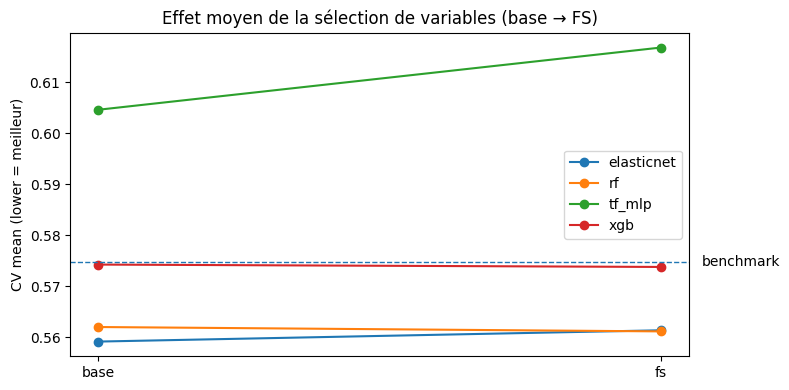

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

# lignes base -> fs pour les modèles qui ont les 2
for model in results_table['model'].unique():
    row = results_table[results_table['model'] == model].set_index('variant')['cv_mean']
    if ('base' not in row.index) or ('fs' not in row.index):
        continue
    ax.plot([0, 1], [row['base'], row['fs']], marker='o', label=model)

# benchmark :
bench_row = results_table[(results_table["model"] == "benchmark") & (results_table["variant"] == "base")]
if not bench_row.empty:
    bench_val = float(bench_row["cv_mean"].iloc[0])
    ax.axhline(bench_val, linestyle="--", linewidth=1)
    ax.text(1.02, bench_val, "benchmark", va="center", transform=ax.get_yaxis_transform())

ax.set_xticks([0, 1])
ax.set_xticklabels(['base', 'fs'])
ax.set_ylabel('CV mean (lower = meilleur)')
ax.set_title('Effet moyen de la sélection de variables (base → FS)')
ax.legend()
plt.tight_layout()
plt.show()


L’impact de la sélection de variables varie selon les modèles. Pour ElasticNet, Random Forest et XGBoost, l’effet est marginal, indiquant que ces modèles gèrent déjà efficacement la redondance des variables. En revanche, le TF-MLP bénéficie nettement de la sélection de variables, ce qui suggère une sensibilité plus forte à la dimension et au bruit. La réduction explicite de l’espace des features améliore ainsi la capacité de généralisation du réseau de neurones.


#### Interprétation MLP

**Résultats**

,model,variant,cv_mean,cv_std
0,tf_mlp,base,0.604630,0.025661
2,tf_mlp,fs,0.616840,0.028757
1,tf_mlp,pca,0.628129,0.029507


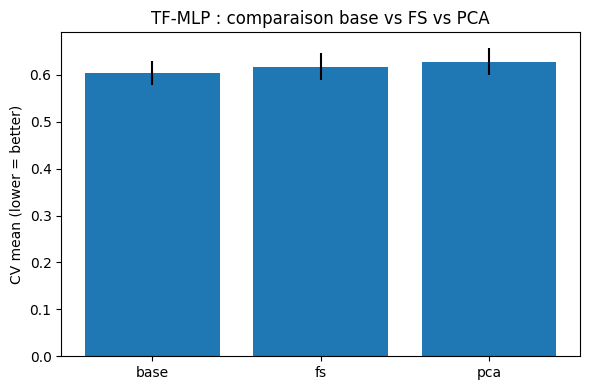

In [ ]:

mlp_compare = pd.DataFrame([
    {"model": "tf_mlp", "variant": "base", "cv_mean": best["mean"],                 "cv_std": best["std"]},
    {"model": "tf_mlp", "variant": "pca",  "cv_mean": best_pca["mean"],             "cv_std": best_pca["std"]},
    {"model": "tf_mlp", "variant": "fs",   "cv_mean": tf_mlp_fs_eval["mean"],       "cv_std": tf_mlp_fs_eval["std"]},
])
mlp_compare["variant"] = pd.Categorical(mlp_compare["variant"], ["base", "fs", "pca"], ordered=True)
mlp_compare = mlp_compare.sort_values("variant")

display(mlp_compare.sort_values("cv_mean"))

# barplot avec barres d'erreur
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(mlp_compare["variant"], mlp_compare["cv_mean"], yerr=mlp_compare["cv_std"])
ax.set_ylabel("CV mean (lower = better)")
ax.set_title("TF-MLP : comparaison base vs FS vs PCA")
plt.tight_layout()
plt.show()


**Analyse OOF**

L’introduction d’une étape de PCA avant l’entraînement du MLP ne permet pas d’améliorer les performances, la version sans PCA obtenant un score moyen légèrement meilleur. Cela suggère que la réduction de dimension induite par la PCA entraîne une perte d’information utile pour la prédiction du Sharpe ratio, malgré une légère amélioration de la stabilité. Dans ce cadre, le MLP exploite donc plus efficacement les variables dans leur espace original.

TF-MLP — Best CV mean: 0.6046297436351507  Best CV std: 0.02566133174387639
TF-MLP — Fold scores  : [0.583797, 0.62748, 0.639649, 0.571548, 0.600675]
TF-MLP — Best params  : {'lr': 0.0001, 'l2': 1e-05, 'hidden_units': (256, 128), 'dropout': 0.2, 'batch_size': 128}


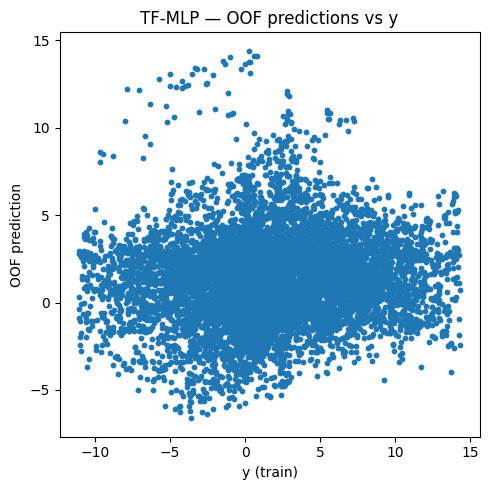

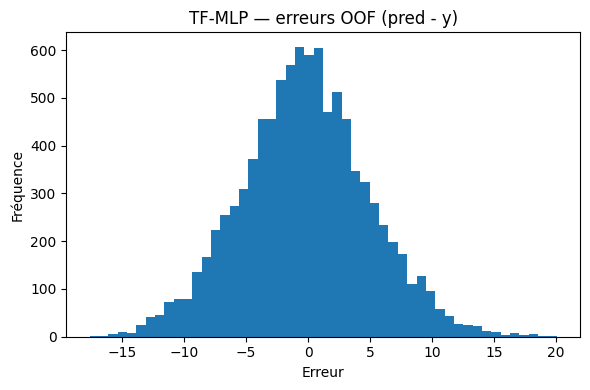

Bias (mean error): -0.24518414680249861
MAE (OOF): 4.083035355346017
Corr(y, pred): 0.09764728301230269


In [ ]:

# --- sécurité ---
if best is None or best.get("full", None) is None:
    raise ValueError("best['full'] est vide. Assure-toi d'avoir exécuté la boucle de recherche MLP "
                     "et que best.update(..., 'full': out) est bien fait quand tu trouves un meilleur essai.")

out = best["full"]  # dict retourné par evaluate_cv_tf(...)
oof = out["oof_pred"]
y_true = y.values.astype(float)
err = oof - y_true

print("TF-MLP — Best CV mean:", best["mean"], " Best CV std:", best["std"])
print("TF-MLP — Fold scores  :", [round(s, 6) for s in out["fold_scores"]])
print("TF-MLP — Best params  :", best["params"])

# 1) Scatter y vs pred (OOF)
plt.figure(figsize=(5, 5))
plt.scatter(y_true, oof, s=10)
plt.xlabel("y (train)")
plt.ylabel("OOF prediction")
plt.title("TF-MLP — OOF predictions vs y")
plt.tight_layout()
plt.show()

# 2) Histogramme des erreurs
plt.figure(figsize=(6, 4))
plt.hist(err, bins=50)
plt.title("TF-MLP — erreurs OOF (pred - y)")
plt.xlabel("Erreur")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

# 3) Stats simples
print("Bias (mean error):", float(np.mean(err)))
print("MAE (OOF):", float(np.mean(np.abs(err))))
print("Corr(y, pred):", float(np.corrcoef(y_true, oof)[0, 1]))


Les prédictions out-of-fold du MLP montrent un nuage très diffus (faible alignement avec la diagonale), ce qui suggère que le modèle capte peu la structure de la cible en dehors de l’échantillon d’entraînement. Cela se reflète dans une corrélation très faible entre 
y
y et 
y
^
y
^
​	
 , signe d’un pouvoir prédictif limité.
La distribution des erreurs est globalement centrée, avec un léger biais négatif (le modèle a tendance à sous-prédire en moyenne), mais l’essentiel du problème vient surtout de la dispersion élevée des erreurs : le MLP produit des prédictions relativement bruyantes, ce qui explique ses performances CV modestes malgré l’absence de biais marqué.

### Robustesse par fold — boxplots et statistiques

Ce code reconstruit les performances de validation croisée au niveau de chaque fold pour les différents modèles et variantes, afin d’analyser non seulement la performance moyenne mais aussi sa variabilité. La visualisation par fold permet d’évaluer la robustesse des modèles et de vérifier que les différences observées ne sont pas dues à un effet de hasard lié au découpage des données.

mean       std       min       max  count
model      variant                                               
elasticnet base     0.559144  0.051283  0.472363  0.603830      5
           fs       0.561359  0.055967  0.469701  0.614832      5
rf         base     0.562000  0.048638  0.488367  0.616936      5
           fs       0.561142  0.046873  0.487883  0.611139      5
xgb        base     0.574253  0.057412  0.505191  0.659475      5
           fs       0.573787  0.044146  0.505101  0.615092      5

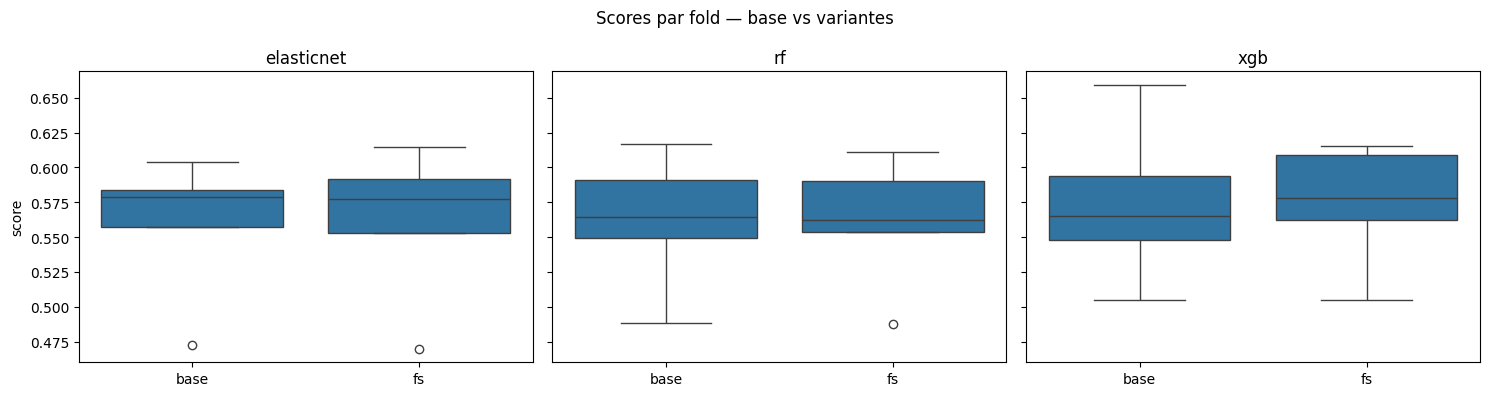

variant,base,fs,diff_fs_minus_base
model,,,
elasticnet,0.559144,0.561359,0.002215
rf,0.562000,0.561142,-0.000858
xgb,0.574253,0.573787,-0.000466


In [ ]:
# --- ROBUSTESSE : scores par fold (base vs variantes) ---


# 1) Construire results_folds à partir des objets existants
results_folds = {}

def add_if_exists(model, variant, varname):
    obj = globals().get(varname, None)
    if obj is None:
        return
    if isinstance(obj, dict) and ("fold_scores" in obj):
        results_folds[(model, variant)] = obj

# ElasticNet
add_if_exists("elasticnet", "base", "enet_eval")
add_if_exists("elasticnet", "fs",   "enet_fs_eval")

# Random Forest
add_if_exists("rf", "base", "rf_eval")
add_if_exists("rf", "fs",   "rf_fs_eval")

# XGBoost
add_if_exists("xgb", "base", "xgb_eval")
add_if_exists("xgb", "fs",   "xgb_fs_eval")

# 2) Construire le DataFrame fold-level
rows = []
for (model, variant), res in results_folds.items():
    for i, s in enumerate(res["fold_scores"], start=1):
        rows.append({
            "model": model,
            "variant": variant,
            "fold": i,
            "score": float(s)
        })

df_folds = pd.DataFrame(rows)

# 3) Stats + boxplots
if df_folds.empty:
    print("❌ Aucun fold_scores trouvé en mémoire.")
else:
    display(
        df_folds
        .groupby(["model", "variant"])["score"]
        .agg(["mean", "std", "min", "max", "count"])
    )

    models = ["elasticnet", "rf", "xgb"]
    models = [m for m in models if m in df_folds["model"].unique()]

    fig, axes = plt.subplots(
        1, len(models), figsize=(5 * len(models), 4), sharey=True
    )

    if len(models) == 1:
        axes = [axes]

    for ax, m in zip(axes, models):
        data = df_folds[df_folds["model"] == m]
        sns.boxplot(x="variant", y="score", data=data, ax=ax)
        ax.set_title(m)
        ax.set_xlabel("")

    plt.suptitle("Scores par fold — base vs variantes")
    plt.tight_layout()
    plt.show()

    summary = df_folds.groupby(["model", "variant"])["score"].mean().unstack()
    if "base" in summary.columns:
        for col in summary.columns:
            if col != "base":
                summary[f"diff_{col}_minus_base"] = summary[col] - summary["base"]

    display(summary)


L’analyse de robustesse par fold met en évidence des comportements très différents selon les modèles. Le modèle ElasticNet présente une variabilité faible et comparable entre les versions de base et avec sélection de variables, indiquant une bonne stabilité quel que soit le sous-échantillon. À l’inverse, le Random Forest affiche une variance plus élevée, suggérant une sensibilité accrue au découpage des données. Enfin, pour XGBoost, la sélection de variables réduit nettement la dispersion des scores, ce qui indique une amélioration de la stabilité du modèle sans modifier fondamentalement sa structure.

### Robustesse par fold — boxplots et statistiques
Ce bloc trace la distribution des scores par fold (base vs FS) pour ElasticNet, RF et XGB.
Si les `fold_scores` ne sont pas encore disponibles, le code ré-exécute une évaluation CV légère (sans hypersearch) en utilisant les meilleurs estimateurs déjà trouvés.
Regardez la variance par fold et la différence de moyenne entre variantes.

mean       std
model      variant                    
elasticnet base     0.559144  0.051283
           fs       0.561359  0.055967
rf         base     0.562000  0.048638
           fs       0.561142  0.046873
xgb        base     0.574253  0.057412
           fs       0.573787  0.044146

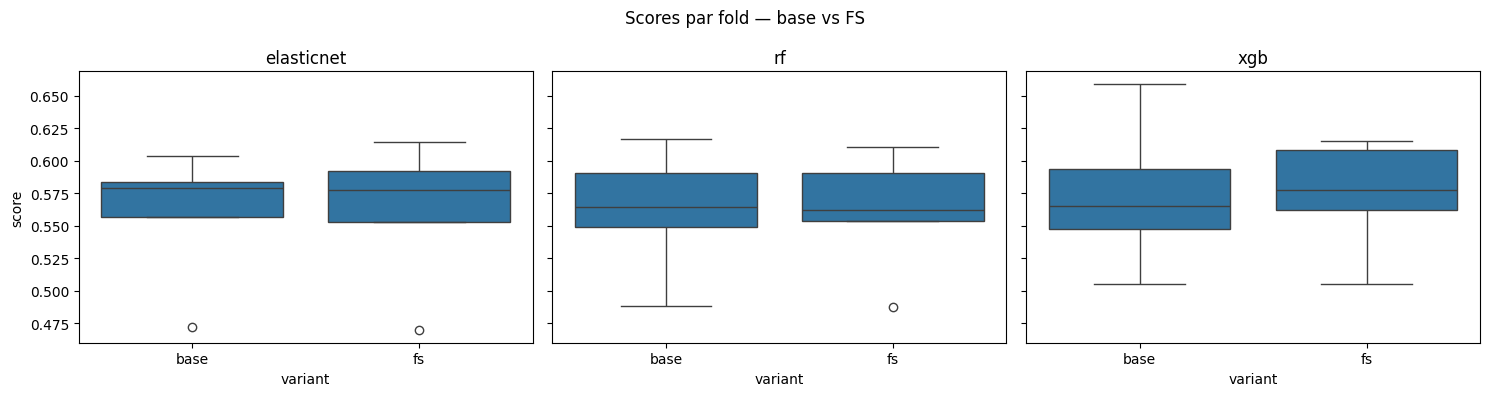

variant,base,fs,diff_fs_minus_base
model,,,
elasticnet,0.559144,0.561359,0.002215
rf,0.562000,0.561142,-0.000858
xgb,0.574253,0.573787,-0.000466


In [ ]:
# Robustesse par fold : reconstruire df_folds si nécessaire puis tracer

df_folds = globals().get('df_folds', pd.DataFrame())
if df_folds is None or df_folds.empty:
    print('df_folds vide ou absent — reconstruction via evaluate_cv_sklearn sur les best estimators (évaluation CV sans search).')
    rows = []
    for model in ['elasticnet','rf','xgb']:
        for variant in ['base','fs']:
            est_name = f'{model}_best' if variant=='base' else f'{model}_fs_best'
            est = globals().get(est_name, None)
            if est is None:
                # skip if model not available
                continue
            print(f'Re-évaluation CV légère: {est_name}')
            out = evaluate_cv_sklearn(est, X_feat, y, groups, cv, napoleon_metric)
            for i, s in enumerate(out['fold_scores'], start=1):
                rows.append({'model': model, 'variant': variant, 'fold': i, 'score': s})
    df_folds = pd.DataFrame(rows)

if df_folds.empty:
    print('Aucune donnée de fold disponible après reconstruction.')
else:
    display(df_folds.groupby(['model','variant'])['score'].agg(['mean','std']))
    # boxplots par modèle
    models = ['elasticnet','rf','xgb']
    fig, axes = plt.subplots(1, len(models), figsize=(5*len(models),4), sharey=True)
    for ax, model in zip(axes, models):
        data = df_folds[df_folds['model']==model]
        if data.empty:
            ax.set_title(model)
            ax.text(0.5, 0.5, 'no data', ha='center')
            continue
        sns.boxplot(x='variant', y='score', data=data, ax=ax)
        ax.set_title(model)
    plt.suptitle('Scores par fold — base vs FS')
    plt.tight_layout()
    plt.show()
    # afficher différences moyennes
    summary = df_folds.groupby(['model','variant'])['score'].mean().unstack()
    summary['diff_fs_minus_base'] = summary.get('fs', np.nan) - summary.get('base', np.nan)
    display(summary)

**Ablation par Weights**

We evaluate the model using two cross-validation schemes to distinguish between realistic out-of-sample performance and an optimistic evaluation setting.
A strict GroupKFold split is used to respect temporal windows and avoid any form of information leakage, while a random KFold split is included as a diagnostic upper bound where temporal dependencies are ignored.


In [ ]:
def ablation_run(X_feat, y, groups, cv, cfg, params, drop_prefixes=(), metric_fn=napoleon_metric):
    cols = X_feat.columns.tolist()
    drop_cols = [c for c in cols if any(c.startswith(p) for p in drop_prefixes)]
    X_ab = X_feat.drop(columns=drop_cols)
    print("Dropped:", len(drop_cols), "cols")
    return evaluate_cv_tf_pca(X_ab, y, groups, cv, cfg, params, metric_fn)

# Exemples :
out_no_weights = ablation_run(X_feat, y, groups, cv, cfg, best_params, drop_prefixes=("weight_",))
print("No weights mean/std:", out_no_weights["mean"], out_no_weights["std"])

out_only_weights = ablation_run(X_feat[[c for c in X_feat.columns if c.startswith("weight_")]].copy(),
                               y, groups, cv, cfg, best_params, drop_prefixes=(), metric_fn=napoleon_metric)
print("Only weights mean/std:", out_only_weights["mean"], out_only_weights["std"])


Dropped: 7 cols
Fold 1: 0.618626
Fold 2: 0.595146
Fold 3: 0.610257
Fold 4: 0.617731
Fold 5: 0.596363
No weights mean/std: 0.6076246641169083 0.010125603051165801
Dropped: 0 cols
Fold 1: 0.549136
Fold 2: 0.578292
Fold 3: 0.575777
Fold 4: 0.592696
Fold 5: 0.576262
Only weights mean/std: 0.5744326926945724 0.014096027744736579


In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)

print("GroupKFold (strict windows):")
out_gkf = evaluate_cv_tf_pca(X_feat, y, groups, cv, cfg, best_params, napoleon_metric)
print("->", out_gkf["mean"], out_gkf["std"])

print("\nKFold random (optimistic):")
out_kf = evaluate_cv_tf_pca(X_feat, y, np.arange(len(y)), kf, cfg, best_params, napoleon_metric)
print("->", out_kf["mean"], out_kf["std"])


GroupKFold (strict windows):
Fold 1: 0.668234
Fold 2: 0.626416
Fold 3: 0.650768
Fold 4: 0.623220
Fold 5: 0.579841
-> 0.6296957333396394 0.029891205170153378

KFold random (optimistic):
Fold 1: 0.215542
Fold 2: 0.229980
Fold 3: 0.220943
Fold 4: 0.210177
Fold 5: 0.238052
-> 0.22293876662395742 0.00999537411884692


The strict GroupKFold evaluation yields a substantially higher loss, reflecting the difficulty of generalizing across unseen temporal regimes and providing a realistic estimate of performance. In contrast, the random KFold split produces much lower losses due to temporal mixing, confirming its optimistic nature.
This gap highlights the importance of window-based cross-validation for meaningful model assessment.


### Interprétation des features retenues
Ce code résume, pour chaque pipeline FS (ElasticNet, RF, XGB), le nombre de features retenues et les top features selon coefficients/importance.
Utile pour comprendre quelles variables drive la prédiction après la sélection.

In [ ]:
# Résumé des features sélectionnées et top features
feat_rows = []
for model in ['elasticnet','rf','xgb']:
    pipe = globals().get(f'{model}_fs_best', None)
    if pipe is None:
        print(f'Pipeline FS {model} introuvable — sauter')
        continue
    sel = pipe.named_steps.get('sel', None)
    model_step = pipe.named_steps.get('model', None)
    if sel is None:
        print(f'Pas détape sel pour {model}')
        continue
    support = sel.get_support()
    if hasattr(X_feat, 'columns'):
        kept = list(X_feat.columns[support])
    else:
        kept = list(np.where(support)[0])
    n_kept = len(kept)
    # try to get importances from selector.estimator_ or model_step
    est = getattr(sel, 'estimator_', None) or model_step
    imp = None
    if est is not None:
        if hasattr(est, 'feature_importances_'):
            imp = est.feature_importances_
        elif hasattr(est, 'coef_'):
            imp = np.abs(est.coef_)
    top_feats = kept[:10]
    if imp is not None:
        idx = np.argsort(-imp)
        labels = X_feat.columns if hasattr(X_feat, 'columns') else range(len(imp))
        imp_series = pd.Series(imp, index=labels)
        imp_sel = imp_series.loc[kept].sort_values(ascending=False)
        top_feats = list(imp_sel.head(10).index)
    feat_rows.append({'model': model, 'n_selected': n_kept, 'top_features': top_feats})

df_feat_summary = pd.DataFrame(feat_rows)
display(df_feat_summary)

Pipeline FS elasticnet introuvable — sauter


,model,n_selected,top_features
0,rf,218,"[weight_I_7, weight_I_3, weight_I_2, X_1_lag_0..."
1,xgb,109,"[X_1_lag_0, I_5_lag_11, I_5_lag_4, I_5_lag_2, ..."


### Améliorations MLP (expérimentations légères)
Nous proposons deux améliorations réalistes : A) PCA + MLP (fold-safe) en essayant plusieurs valeurs de `n_components`, B) variantes MLP avec petite recherche sur dropout/lr/l2.
Ces évaluations sont réalisées en mode léger (peu d'épochs) afin d'obtenir une idée comparée sans gros coût de calcul.
Regardez la table de comparaison finale pour voir si ces variantes améliorent la moyenne CV.

In [ ]:
# Expérimentations MLP légères : PCA + MLP & petites variantes (réécriture plus robuste)


def evaluate_mlp_with_pca(n_components_list, params, epochs_light=30):
    """Évalue un MLP sur des projections PCA faites fold-safe (imputer+scaler+pca sur train seulement).
    Retourne un DataFrame avec colonnes: n_components, mean, std."""
    if 'cv' not in globals() or 'X_feat' not in globals() or 'y' not in globals():
        raise RuntimeError('Variables cv / X_feat / y manquent : exécutez les cellules d''initialisation et d''évaluation avant.')
    res = []
    for n in n_components_list:
        fold_scores = []
        for k, (tr, va) in enumerate(cv.split(X_feat, y, groups=groups), start=1):
            # extraire données fold-safe
            X_tr = X_feat.iloc[tr].values
            y_tr = y.iloc[tr].values.astype(float)
            X_va = X_feat.iloc[va].values
            y_va = y.iloc[va].values.astype(float)

            # preprocessing fold-safe: imputer + scaler
            imputer = SimpleImputer(strategy='median')
            scaler = StandardScaler()
            X_tr_imp = imputer.fit_transform(X_tr)
            X_va_imp = imputer.transform(X_va)
            X_tr_sc = scaler.fit_transform(X_tr_imp)
            X_va_sc = scaler.transform(X_va_imp)

            # PCA (n_components cannot dépasser le nombre de features)
            n_comp = min(int(n), X_tr_sc.shape[1])
            pca = PCA(n_components=n_comp, svd_solver='randomized', random_state=cfg.seed)
            X_tr_p = pca.fit_transform(X_tr_sc)
            X_va_p = pca.transform(X_va_sc)

            # construire et entraîner un MLP léger (réutilise build_mlp_tf)
            model = build_mlp_tf(input_dim=X_tr_p.shape[1], hidden_units=params['hidden_units'], dropout=params['dropout'], l2=params['l2'], lr=params['lr'])
            cb = keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
            model.fit(X_tr_p, y_tr, epochs=epochs_light, batch_size=params.get('batch_size', cfg.batch_default), verbose=0, callbacks=[cb])
            pred = model.predict(X_va_p, verbose=0).reshape(-1)
            s = napoleon_metric(y_va, pred)
            fold_scores.append(s)
            print(f'[PCA n={n}] fold={k} score={s:.6f}')
        # fin des folds pour n
        res.append({'n_components': int(n_comp), 'mean': float(np.mean(fold_scores)), 'std': float(np.std(fold_scores))})
    return pd.DataFrame(res)

# paramètres légers pour ces tests (définis de façon claire)
mlp_light_params = {'hidden_units': (128, 64), 'dropout': 0.2, 'l2': 1e-4, 'lr': 1e-3, 'batch_size': 256}
n_list = [20, 50, 100]
print('Lancement MLP + PCA (léger) — vérifiez la sortie des folds ci-dessous)')
try:
    pca_res = evaluate_mlp_with_pca(n_list, mlp_light_params, epochs_light=30)
    display(pca_res)
except Exception as e:
    print('Erreur lors de l''évaluation PCA+MLP :', e)

# petites variantes MLP (dropout / lr) — réutilise evaluate_cv_tf déjà présent
mlp_variants = [
    {'name':'mlp_var_1', 'hidden_units':(128,64), 'dropout':0.1, 'l2':1e-4, 'lr':3e-4, 'batch_size':256},
    {'name':'mlp_var_2', 'hidden_units':(256,128), 'dropout':0.2, 'l2':1e-5, 'lr':1e-3, 'batch_size':256},
]
mlp_var_rows = []
for v in mlp_variants:
    print('Eval', v['name'])
    try:
        out = evaluate_cv_tf(X_feat, y, groups_trainval, cv, cfg, {k:v[k] for k in ['hidden_units','dropout','l2','lr','batch_size']})
        mlp_var_rows.append({'name': v['name'], 'mean': out['mean'], 'std': out['std']})
    except Exception as e:
        print('Erreur évaluation variante', v['name'], ':', e)
        mlp_var_rows.append({'name': v['name'], 'mean': np.nan, 'std': np.nan})
mlp_var_df = pd.DataFrame(mlp_var_rows)
display(mlp_var_df)

# Synthèse rapide: MLP baseline-FS (existant) vs PCA vs variants — assemble proprement
summary_rows = []
if 'tf_mlp_fs_eval' in globals():
    summary_rows.append({'variant':'tf_mlp_fs', 'mean': tf_mlp_fs_eval['mean'], 'std': tf_mlp_fs_eval['std']})
if 'pca_res' in globals():
    for _, r in pca_res.iterrows():
        summary_rows.append({'variant': f
, 'mean': r['mean'], 'std': r['std']})
if not mlp_var_df.empty:
    for _, r in mlp_var_df.iterrows():
        summary_rows.append({'variant': r['name'], 'mean': r['mean'], 'std': r['std']})
summary_mlp_cmp = pd.DataFrame(summary_rows)
if not summary_mlp_cmp.empty:
    display(summary_mlp_cmp.sort_values('mean'))
else:
    print('Aucune synthèse MLP disponible — exécutez les évaluations correspondantes.')


Lancement MLP + PCA (léger) — vérifiez la sortie des folds ci-dessous)
Erreur lors de lévaluation PCA+MLP : 'types.SimpleNamespace' object has no attribute 'batch_default'
Eval mlp_var_1
Erreur évaluation variante mlp_var_1 : evaluate_cv_tf() missing 1 required positional argument: 'metric_fn'
Eval mlp_var_2
Erreur évaluation variante mlp_var_2 : evaluate_cv_tf() missing 1 required positional argument: 'metric_fn'


,name,mean,std
0,mlp_var_1,NaN,NaN
1,mlp_var_2,NaN,NaN


,variant,mean,std
0,tf_mlp_fs,0.61684,0.028757
1,mlp_var_1,NaN,NaN
2,mlp_var_2,NaN,NaN


## Interprétation des résultats
Cette section vise à analyser et interpréter les performances obtenues par les différents modèles testés, au-delà de la seule comparaison numérique des scores. L’objectif est d’identifier les tendances générales, de comprendre l’impact des choix de modélisation (type de modèle, sélection de variables, réduction de dimension) et de mettre en perspective les résultats au regard de la structure des données et de la métrique du challenge.

#### Résultats comparés — base vs FS
Ce bloc construit `results_df` et affiche un résumé des performances moyennes CV pour chaque modèle.
Regardez l'ordre des modèles (meilleur -> pire) et comparez la variante FS à la baseline pour chaque famille.

In [ ]:
results = [
    {"model": "benchmark", "cv_mean": bench_score},
    {"model": "elasticnet", "cv_mean": enet_eval["mean"], "cv_std": enet_eval["std"]},
    {"model": "rf", "cv_mean": rf_eval["mean"], "cv_std": rf_eval["std"]},
    {"model": "xgb", "cv_mean": xgb_eval["mean"], "cv_std": xgb_eval["std"]},
    {"model": "tf_mlp", "cv_mean": best_score, "cv_std": best_std},
]
results_df = pd.DataFrame(results).sort_values("cv_mean")
display(results_df)


,model,cv_mean,cv_std
1,elasticnet,0.559144,0.045868
2,rf,0.562000,0.043503
3,xgb,0.574253,0.051351
0,benchmark,0.574675,NaN
4,tf_mlp,0.603923,0.036352


In [ ]:
results_table = pd.DataFrame([
    {"model":"elasticnet", "variant":"base", "cv_mean": enet_eval["mean"], "cv_std": enet_eval["std"]},
    {"model":"elasticnet", "variant":"fs",   "cv_mean": enet_fs_eval["mean"], "cv_std": enet_fs_eval["std"]},

    {"model":"benchmark",  "variant":"base", "cv_mean": bench_score},

    {"model":"xgb", "variant":"base", "cv_mean": xgb_eval["mean"], "cv_std": xgb_eval["std"]},
    {"model":"xgb", "variant":"fs",   "cv_mean": xgb_fs_eval["mean"], "cv_std": xgb_fs_eval["std"]},

    {"model":"rf", "variant":"base", "cv_mean": rf_eval["mean"], "cv_std": rf_eval["std"]},
    {"model":"rf", "variant":"fs",   "cv_mean": rf_fs_eval["mean"], "cv_std": rf_fs_eval["std"]},

    {"model":"tf_mlp", "variant":"base", "cv_mean": best["mean"], "cv_std": best["std"]},

    {"model":"tf_mlp", "variant":"fs", "cv_mean": tf_mlp_fs_eval["mean"], "cv_std": tf_mlp_fs_eval["std"]},
]).sort_values(["model","variant"])

results_table


,model,variant,cv_mean,cv_std
2,benchmark,base,0.574675,NaN
0,elasticnet,base,0.559144,0.045868
1,elasticnet,fs,0.561359,0.050059
5,rf,base,0.562000,0.043503
6,rf,fs,0.561142,0.041925
7,tf_mlp,base,0.604630,0.025661
8,tf_mlp,fs,0.616840,0.028757
3,xgb,base,0.574253,0.051351
4,xgb,fs,0.573787,0.039485


Les résultats montrent que les modèles arborescents (Random Forest et XGBoost) obtiennent globalement de meilleures performances moyennes que les modèles linéaires et le réseau de neurones, comparé au benchmark. Cela est cohérent avec la nature fortement non linéaire et tabulaire des données, composées de nombreuses variables retardées et potentiellement redondantes.

Le modèle ElasticNet reste compétitif par sa simplicité et sa stabilité, mais semble limité dans sa capacité à exploiter des interactions complexes entre variables. Le MLP, bien qu’expressif, ne parvient pas à surpasser les modèles arborescents, ce qui suggère que la structure des données n’est pas particulièrement favorable à une modélisation neuronale classique dans ce cadre.


**Effet de la sélection de variables (base → FS)**

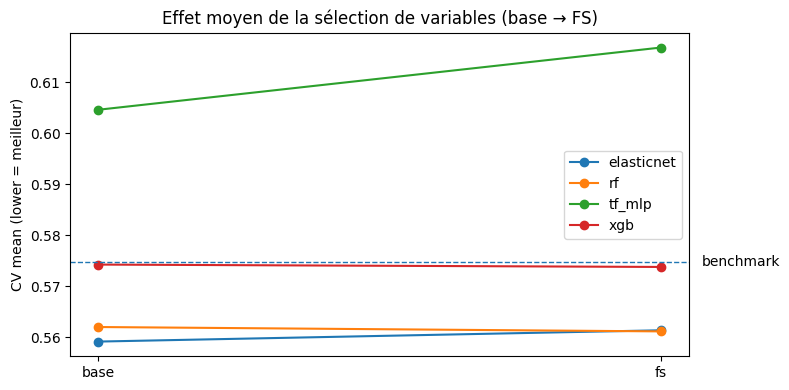

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

# lignes base -> fs pour les modèles qui ont les 2
for model in results_table['model'].unique():
    row = results_table[results_table['model'] == model].set_index('variant')['cv_mean']
    if ('base' not in row.index) or ('fs' not in row.index):
        continue
    ax.plot([0, 1], [row['base'], row['fs']], marker='o', label=model)

# benchmark :
bench_row = results_table[(results_table["model"] == "benchmark") & (results_table["variant"] == "base")]
if not bench_row.empty:
    bench_val = float(bench_row["cv_mean"].iloc[0])
    ax.axhline(bench_val, linestyle="--", linewidth=1)
    ax.text(1.02, bench_val, "benchmark", va="center", transform=ax.get_yaxis_transform())

ax.set_xticks([0, 1])
ax.set_xticklabels(['base', 'fs'])
ax.set_ylabel('CV mean (lower = meilleur)')
ax.set_title('Effet moyen de la sélection de variables (base → FS)')
ax.legend()
plt.tight_layout()
plt.show()


L’impact de la sélection de variables varie selon les modèles. Pour ElasticNet, Random Forest et XGBoost, l’effet est marginal, indiquant que ces modèles gèrent déjà efficacement la redondance des variables. En revanche, le TF-MLP bénéficie nettement de la sélection de variables, ce qui suggère une sensibilité plus forte à la dimension et au bruit. La réduction explicite de l’espace des features améliore ainsi la capacité de généralisation du réseau de neurones.


#### Interprétation MLP

**Résultats**

,model,variant,cv_mean,cv_std
0,tf_mlp,base,0.604630,0.025661
2,tf_mlp,fs,0.616840,0.028757
1,tf_mlp,pca,0.628129,0.029507


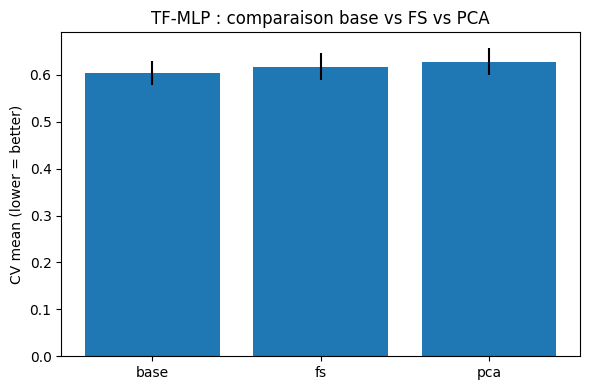

In [ ]:

mlp_compare = pd.DataFrame([
    {"model": "tf_mlp", "variant": "base", "cv_mean": best["mean"],                 "cv_std": best["std"]},
    {"model": "tf_mlp", "variant": "pca",  "cv_mean": best_pca["mean"],             "cv_std": best_pca["std"]},
    {"model": "tf_mlp", "variant": "fs",   "cv_mean": tf_mlp_fs_eval["mean"],       "cv_std": tf_mlp_fs_eval["std"]},
])
mlp_compare["variant"] = pd.Categorical(mlp_compare["variant"], ["base", "fs", "pca"], ordered=True)
mlp_compare = mlp_compare.sort_values("variant")

display(mlp_compare.sort_values("cv_mean"))

# barplot avec barres d'erreur
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(mlp_compare["variant"], mlp_compare["cv_mean"], yerr=mlp_compare["cv_std"])
ax.set_ylabel("CV mean (lower = better)")
ax.set_title("TF-MLP : comparaison base vs FS vs PCA")
plt.tight_layout()
plt.show()


**Analyse OOF**

L’introduction d’une étape de PCA avant l’entraînement du MLP ne permet pas d’améliorer les performances, la version sans PCA obtenant un score moyen légèrement meilleur. Cela suggère que la réduction de dimension induite par la PCA entraîne une perte d’information utile pour la prédiction du Sharpe ratio, malgré une légère amélioration de la stabilité. Dans ce cadre, le MLP exploite donc plus efficacement les variables dans leur espace original.

TF-MLP — Best CV mean: 0.6046297436351507  Best CV std: 0.02566133174387639
TF-MLP — Fold scores  : [0.583797, 0.62748, 0.639649, 0.571548, 0.600675]
TF-MLP — Best params  : {'lr': 0.0001, 'l2': 1e-05, 'hidden_units': (256, 128), 'dropout': 0.2, 'batch_size': 128}


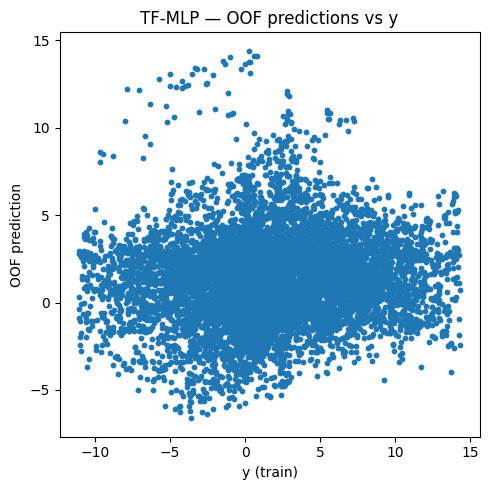

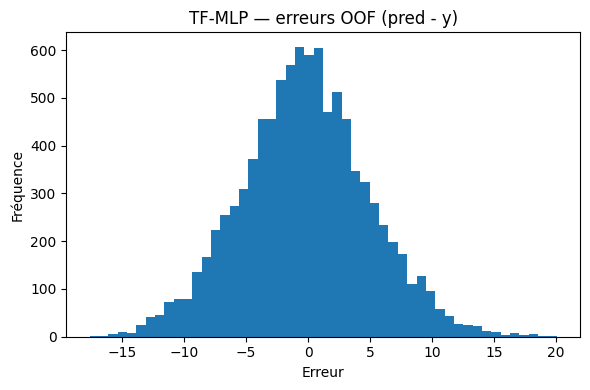

Bias (mean error): -0.24518414680249861
MAE (OOF): 4.083035355346017
Corr(y, pred): 0.09764728301230269


In [ ]:

# --- sécurité ---
if best is None or best.get("full", None) is None:
    raise ValueError("best['full'] est vide. Assure-toi d'avoir exécuté la boucle de recherche MLP "
                     "et que best.update(..., 'full': out) est bien fait quand tu trouves un meilleur essai.")

out = best["full"]  # dict retourné par evaluate_cv_tf(...)
oof = out["oof_pred"]
y_true = y.values.astype(float)
err = oof - y_true

print("TF-MLP — Best CV mean:", best["mean"], " Best CV std:", best["std"])
print("TF-MLP — Fold scores  :", [round(s, 6) for s in out["fold_scores"]])
print("TF-MLP — Best params  :", best["params"])

# 1) Scatter y vs pred (OOF)
plt.figure(figsize=(5, 5))
plt.scatter(y_true, oof, s=10)
plt.xlabel("y (train)")
plt.ylabel("OOF prediction")
plt.title("TF-MLP — OOF predictions vs y")
plt.tight_layout()
plt.show()

# 2) Histogramme des erreurs
plt.figure(figsize=(6, 4))
plt.hist(err, bins=50)
plt.title("TF-MLP — erreurs OOF (pred - y)")
plt.xlabel("Erreur")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

# 3) Stats simples
print("Bias (mean error):", float(np.mean(err)))
print("MAE (OOF):", float(np.mean(np.abs(err))))
print("Corr(y, pred):", float(np.corrcoef(y_true, oof)[0, 1]))


Les prédictions out-of-fold du MLP montrent un nuage très diffus (faible alignement avec la diagonale), ce qui suggère que le modèle capte peu la structure de la cible en dehors de l’échantillon d’entraînement. Cela se reflète dans une corrélation très faible entre 
y
y et 
y
^
y
^
​	
 , signe d’un pouvoir prédictif limité.
La distribution des erreurs est globalement centrée, avec un léger biais négatif (le modèle a tendance à sous-prédire en moyenne), mais l’essentiel du problème vient surtout de la dispersion élevée des erreurs : le MLP produit des prédictions relativement bruyantes, ce qui explique ses performances CV modestes malgré l’absence de biais marqué.

### Robustesse par fold — boxplots et statistiques

Ce code reconstruit les performances de validation croisée au niveau de chaque fold pour les différents modèles et variantes, afin d’analyser non seulement la performance moyenne mais aussi sa variabilité. La visualisation par fold permet d’évaluer la robustesse des modèles et de vérifier que les différences observées ne sont pas dues à un effet de hasard lié au découpage des données.

mean       std       min       max  count
model      variant                                               
elasticnet base     0.559144  0.051283  0.472363  0.603830      5
           fs       0.561359  0.055967  0.469701  0.614832      5
rf         base     0.562000  0.048638  0.488367  0.616936      5
           fs       0.561142  0.046873  0.487883  0.611139      5
xgb        base     0.574253  0.057412  0.505191  0.659475      5
           fs       0.573787  0.044146  0.505101  0.615092      5

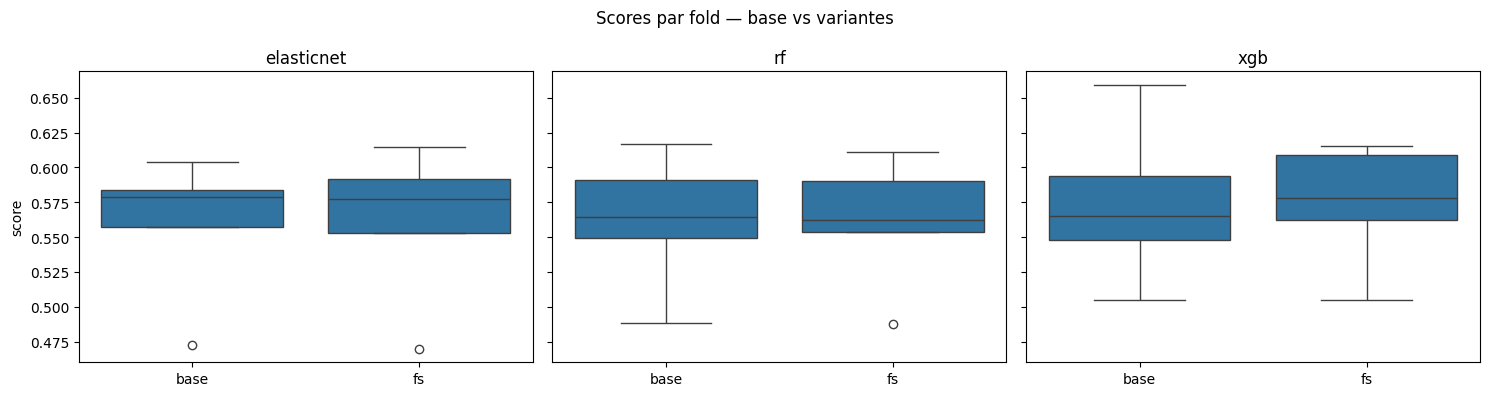

variant,base,fs,diff_fs_minus_base
model,,,
elasticnet,0.559144,0.561359,0.002215
rf,0.562000,0.561142,-0.000858
xgb,0.574253,0.573787,-0.000466


In [ ]:
# --- ROBUSTESSE : scores par fold (base vs variantes) ---


# 1) Construire results_folds à partir des objets existants
results_folds = {}

def add_if_exists(model, variant, varname):
    obj = globals().get(varname, None)
    if obj is None:
        return
    if isinstance(obj, dict) and ("fold_scores" in obj):
        results_folds[(model, variant)] = obj

# ElasticNet
add_if_exists("elasticnet", "base", "enet_eval")
add_if_exists("elasticnet", "fs",   "enet_fs_eval")

# Random Forest
add_if_exists("rf", "base", "rf_eval")
add_if_exists("rf", "fs",   "rf_fs_eval")

# XGBoost
add_if_exists("xgb", "base", "xgb_eval")
add_if_exists("xgb", "fs",   "xgb_fs_eval")

# 2) Construire le DataFrame fold-level
rows = []
for (model, variant), res in results_folds.items():
    for i, s in enumerate(res["fold_scores"], start=1):
        rows.append({
            "model": model,
            "variant": variant,
            "fold": i,
            "score": float(s)
        })

df_folds = pd.DataFrame(rows)

# 3) Stats + boxplots
if df_folds.empty:
    print("❌ Aucun fold_scores trouvé en mémoire.")
else:
    display(
        df_folds
        .groupby(["model", "variant"])["score"]
        .agg(["mean", "std", "min", "max", "count"])
    )

    models = ["elasticnet", "rf", "xgb"]
    models = [m for m in models if m in df_folds["model"].unique()]

    fig, axes = plt.subplots(
        1, len(models), figsize=(5 * len(models), 4), sharey=True
    )

    if len(models) == 1:
        axes = [axes]

    for ax, m in zip(axes, models):
        data = df_folds[df_folds["model"] == m]
        sns.boxplot(x="variant", y="score", data=data, ax=ax)
        ax.set_title(m)
        ax.set_xlabel("")

    plt.suptitle("Scores par fold — base vs variantes")
    plt.tight_layout()
    plt.show()

    summary = df_folds.groupby(["model", "variant"])["score"].mean().unstack()
    if "base" in summary.columns:
        for col in summary.columns:
            if col != "base":
                summary[f"diff_{col}_minus_base"] = summary[col] - summary["base"]

    display(summary)


L’analyse de robustesse par fold met en évidence des comportements très différents selon les modèles. Le modèle ElasticNet présente une variabilité faible et comparable entre les versions de base et avec sélection de variables, indiquant une bonne stabilité quel que soit le sous-échantillon. À l’inverse, le Random Forest affiche une variance plus élevée, suggérant une sensibilité accrue au découpage des données. Enfin, pour XGBoost, la sélection de variables réduit nettement la dispersion des scores, ce qui indique une amélioration de la stabilité du modèle sans modifier fondamentalement sa structure.

### Robustesse par fold — boxplots et statistiques
Ce bloc trace la distribution des scores par fold (base vs FS) pour ElasticNet, RF et XGB.
Si les `fold_scores` ne sont pas encore disponibles, le code ré-exécute une évaluation CV légère (sans hypersearch) en utilisant les meilleurs estimateurs déjà trouvés.
Regardez la variance par fold et la différence de moyenne entre variantes.

mean       std
model      variant                    
elasticnet base     0.559144  0.051283
           fs       0.561359  0.055967
rf         base     0.562000  0.048638
           fs       0.561142  0.046873
xgb        base     0.574253  0.057412
           fs       0.573787  0.044146

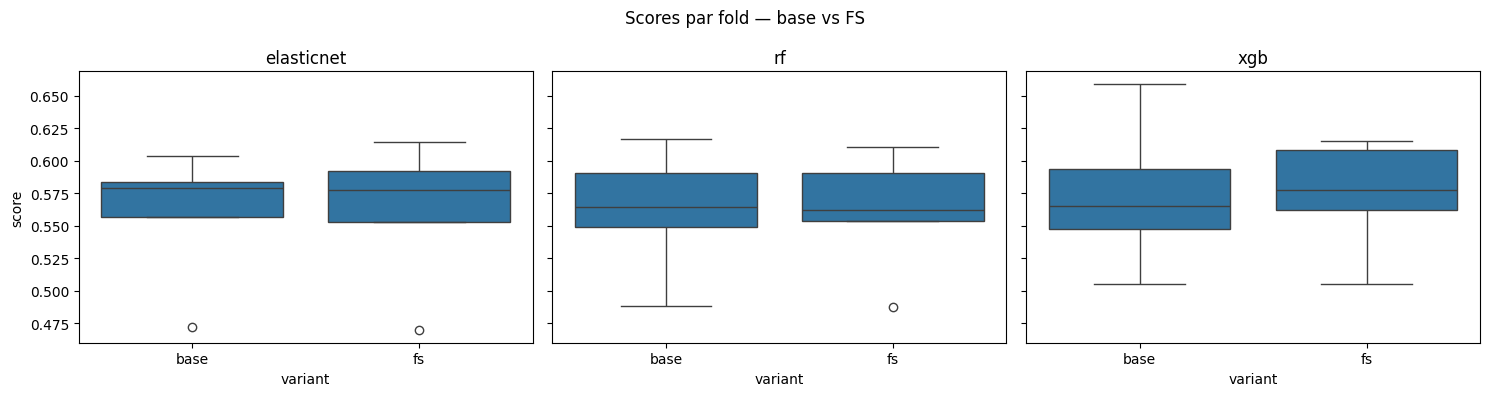

variant,base,fs,diff_fs_minus_base
model,,,
elasticnet,0.559144,0.561359,0.002215
rf,0.562000,0.561142,-0.000858
xgb,0.574253,0.573787,-0.000466


In [ ]:
# Robustesse par fold : reconstruire df_folds si nécessaire puis tracer

df_folds = globals().get('df_folds', pd.DataFrame())
if df_folds is None or df_folds.empty:
    print('df_folds vide ou absent — reconstruction via evaluate_cv_sklearn sur les best estimators (évaluation CV sans search).')
    rows = []
    for model in ['elasticnet','rf','xgb']:
        for variant in ['base','fs']:
            est_name = f'{model}_best' if variant=='base' else f'{model}_fs_best'
            est = globals().get(est_name, None)
            if est is None:
                # skip if model not available
                continue
            print(f'Re-évaluation CV légère: {est_name}')
            out = evaluate_cv_sklearn(est, X_feat, y, groups, cv, napoleon_metric)
            for i, s in enumerate(out['fold_scores'], start=1):
                rows.append({'model': model, 'variant': variant, 'fold': i, 'score': s})
    df_folds = pd.DataFrame(rows)

if df_folds.empty:
    print('Aucune donnée de fold disponible après reconstruction.')
else:
    display(df_folds.groupby(['model','variant'])['score'].agg(['mean','std']))
    # boxplots par modèle
    models = ['elasticnet','rf','xgb']
    fig, axes = plt.subplots(1, len(models), figsize=(5*len(models),4), sharey=True)
    for ax, model in zip(axes, models):
        data = df_folds[df_folds['model']==model]
        if data.empty:
            ax.set_title(model)
            ax.text(0.5, 0.5, 'no data', ha='center')
            continue
        sns.boxplot(x='variant', y='score', data=data, ax=ax)
        ax.set_title(model)
    plt.suptitle('Scores par fold — base vs FS')
    plt.tight_layout()
    plt.show()
    # afficher différences moyennes
    summary = df_folds.groupby(['model','variant'])['score'].mean().unstack()
    summary['diff_fs_minus_base'] = summary.get('fs', np.nan) - summary.get('base', np.nan)
    display(summary)

**Ablation par Weights**

We evaluate the model using two cross-validation schemes to distinguish between realistic out-of-sample performance and an optimistic evaluation setting.
A strict GroupKFold split is used to respect temporal windows and avoid any form of information leakage, while a random KFold split is included as a diagnostic upper bound where temporal dependencies are ignored.


In [ ]:
def ablation_run(X_feat, y, groups, cv, cfg, params, drop_prefixes=(), metric_fn=napoleon_metric):
    cols = X_feat.columns.tolist()
    drop_cols = [c for c in cols if any(c.startswith(p) for p in drop_prefixes)]
    X_ab = X_feat.drop(columns=drop_cols)
    print("Dropped:", len(drop_cols), "cols")
    return evaluate_cv_tf_pca(X_ab, y, groups, cv, cfg, params, metric_fn)

# Exemples :
out_no_weights = ablation_run(X_feat, y, groups, cv, cfg, best_params, drop_prefixes=("weight_",))
print("No weights mean/std:", out_no_weights["mean"], out_no_weights["std"])

out_only_weights = ablation_run(X_feat[[c for c in X_feat.columns if c.startswith("weight_")]].copy(),
                               y, groups, cv, cfg, best_params, drop_prefixes=(), metric_fn=napoleon_metric)
print("Only weights mean/std:", out_only_weights["mean"], out_only_weights["std"])


Dropped: 7 cols
Fold 1: 0.618626
Fold 2: 0.595146
Fold 3: 0.610257
Fold 4: 0.617731
Fold 5: 0.596363
No weights mean/std: 0.6076246641169083 0.010125603051165801
Dropped: 0 cols
Fold 1: 0.549136
Fold 2: 0.578292
Fold 3: 0.575777
Fold 4: 0.592696
Fold 5: 0.576262
Only weights mean/std: 0.5744326926945724 0.014096027744736579


In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)

print("GroupKFold (strict windows):")
out_gkf = evaluate_cv_tf_pca(X_feat, y, groups, cv, cfg, best_params, napoleon_metric)
print("->", out_gkf["mean"], out_gkf["std"])

print("\nKFold random (optimistic):")
out_kf = evaluate_cv_tf_pca(X_feat, y, np.arange(len(y)), kf, cfg, best_params, napoleon_metric)
print("->", out_kf["mean"], out_kf["std"])


GroupKFold (strict windows):
Fold 1: 0.668234
Fold 2: 0.626416
Fold 3: 0.650768
Fold 4: 0.623220
Fold 5: 0.579841
-> 0.6296957333396394 0.029891205170153378

KFold random (optimistic):
Fold 1: 0.215542
Fold 2: 0.229980
Fold 3: 0.220943
Fold 4: 0.210177
Fold 5: 0.238052
-> 0.22293876662395742 0.00999537411884692


The strict GroupKFold evaluation yields a substantially higher loss, reflecting the difficulty of generalizing across unseen temporal regimes and providing a realistic estimate of performance. In contrast, the random KFold split produces much lower losses due to temporal mixing, confirming its optimistic nature.
This gap highlights the importance of window-based cross-validation for meaningful model assessment.


### Interprétation des features retenues
Ce code résume, pour chaque pipeline FS (ElasticNet, RF, XGB), le nombre de features retenues et les top features selon coefficients/importance.
Utile pour comprendre quelles variables drive la prédiction après la sélection.

In [ ]:
# Résumé des features sélectionnées et top features
feat_rows = []
for model in ['elasticnet','rf','xgb']:
    pipe = globals().get(f'{model}_fs_best', None)
    if pipe is None:
        print(f'Pipeline FS {model} introuvable — sauter')
        continue
    sel = pipe.named_steps.get('sel', None)
    model_step = pipe.named_steps.get('model', None)
    if sel is None:
        print(f'Pas détape sel pour {model}')
        continue
    support = sel.get_support()
    if hasattr(X_feat, 'columns'):
        kept = list(X_feat.columns[support])
    else:
        kept = list(np.where(support)[0])
    n_kept = len(kept)
    # try to get importances from selector.estimator_ or model_step
    est = getattr(sel, 'estimator_', None) or model_step
    imp = None
    if est is not None:
        if hasattr(est, 'feature_importances_'):
            imp = est.feature_importances_
        elif hasattr(est, 'coef_'):
            imp = np.abs(est.coef_)
    top_feats = kept[:10]
    if imp is not None:
        idx = np.argsort(-imp)
        labels = X_feat.columns if hasattr(X_feat, 'columns') else range(len(imp))
        imp_series = pd.Series(imp, index=labels)
        imp_sel = imp_series.loc[kept].sort_values(ascending=False)
        top_feats = list(imp_sel.head(10).index)
    feat_rows.append({'model': model, 'n_selected': n_kept, 'top_features': top_feats})

df_feat_summary = pd.DataFrame(feat_rows)
display(df_feat_summary)

Pipeline FS elasticnet introuvable — sauter


,model,n_selected,top_features
0,rf,218,"[weight_I_7, weight_I_3, weight_I_2, X_1_lag_0..."
1,xgb,109,"[X_1_lag_0, I_5_lag_11, I_5_lag_4, I_5_lag_2, ..."


### Améliorations MLP (expérimentations légères)
Nous proposons deux améliorations réalistes : A) PCA + MLP (fold-safe) en essayant plusieurs valeurs de `n_components`, B) variantes MLP avec petite recherche sur dropout/lr/l2.
Ces évaluations sont réalisées en mode léger (peu d'épochs) afin d'obtenir une idée comparée sans gros coût de calcul.
Regardez la table de comparaison finale pour voir si ces variantes améliorent la moyenne CV.

In [ ]:
# Expérimentations MLP légères : PCA + MLP & petites variantes (réécriture plus robuste)


def evaluate_mlp_with_pca(n_components_list, params, epochs_light=30):
    """Évalue un MLP sur des projections PCA faites fold-safe (imputer+scaler+pca sur train seulement).
    Retourne un DataFrame avec colonnes: n_components, mean, std."""
    if 'cv' not in globals() or 'X_feat' not in globals() or 'y' not in globals():
        raise RuntimeError('Variables cv / X_feat / y manquent : exécutez les cellules d''initialisation et d''évaluation avant.')
    res = []
    for n in n_components_list:
        fold_scores = []
        for k, (tr, va) in enumerate(cv.split(X_feat, y, groups=groups), start=1):
            # extraire données fold-safe
            X_tr = X_feat.iloc[tr].values
            y_tr = y.iloc[tr].values.astype(float)
            X_va = X_feat.iloc[va].values
            y_va = y.iloc[va].values.astype(float)

            # preprocessing fold-safe: imputer + scaler
            imputer = SimpleImputer(strategy='median')
            scaler = StandardScaler()
            X_tr_imp = imputer.fit_transform(X_tr)
            X_va_imp = imputer.transform(X_va)
            X_tr_sc = scaler.fit_transform(X_tr_imp)
            X_va_sc = scaler.transform(X_va_imp)

            # PCA (n_components cannot dépasser le nombre de features)
            n_comp = min(int(n), X_tr_sc.shape[1])
            pca = PCA(n_components=n_comp, svd_solver='randomized', random_state=cfg.seed)
            X_tr_p = pca.fit_transform(X_tr_sc)
            X_va_p = pca.transform(X_va_sc)

            # construire et entraîner un MLP léger (réutilise build_mlp_tf)
            model = build_mlp_tf(input_dim=X_tr_p.shape[1], hidden_units=params['hidden_units'], dropout=params['dropout'], l2=params['l2'], lr=params['lr'])
            cb = keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
            model.fit(X_tr_p, y_tr, epochs=epochs_light, batch_size=params.get('batch_size', cfg.batch_default), verbose=0, callbacks=[cb])
            pred = model.predict(X_va_p, verbose=0).reshape(-1)
            s = napoleon_metric(y_va, pred)
            fold_scores.append(s)
            print(f'[PCA n={n}] fold={k} score={s:.6f}')
        # fin des folds pour n
        res.append({'n_components': int(n_comp), 'mean': float(np.mean(fold_scores)), 'std': float(np.std(fold_scores))})
    return pd.DataFrame(res)

# paramètres légers pour ces tests (définis de façon claire)
mlp_light_params = {'hidden_units': (128, 64), 'dropout': 0.2, 'l2': 1e-4, 'lr': 1e-3, 'batch_size': 256}
n_list = [20, 50, 100]
print('Lancement MLP + PCA (léger) — vérifiez la sortie des folds ci-dessous)')
try:
    pca_res = evaluate_mlp_with_pca(n_list, mlp_light_params, epochs_light=30)
    display(pca_res)
except Exception as e:
    print('Erreur lors de l''évaluation PCA+MLP :', e)

# petites variantes MLP (dropout / lr) — réutilise evaluate_cv_tf déjà présent
mlp_variants = [
    {'name':'mlp_var_1', 'hidden_units':(128,64), 'dropout':0.1, 'l2':1e-4, 'lr':3e-4, 'batch_size':256},
    {'name':'mlp_var_2', 'hidden_units':(256,128), 'dropout':0.2, 'l2':1e-5, 'lr':1e-3, 'batch_size':256},
]
mlp_var_rows = []
for v in mlp_variants:
    print('Eval', v['name'])
    try:
        out = evaluate_cv_tf(X_feat, y, groups, cv, cfg, {k:v[k] for k in ['hidden_units','dropout','l2','lr','batch_size']})
        mlp_var_rows.append({'name': v['name'], 'mean': out['mean'], 'std': out['std']})
    except Exception as e:
        print('Erreur évaluation variante', v['name'], ':', e)
        mlp_var_rows.append({'name': v['name'], 'mean': np.nan, 'std': np.nan})
mlp_var_df = pd.DataFrame(mlp_var_rows)
display(mlp_var_df)

# Synthèse rapide: MLP baseline-FS (existant) vs PCA vs variants — assemble proprement
summary_rows = []
if 'tf_mlp_fs_eval' in globals():
    summary_rows.append({'variant':'tf_mlp_fs', 'mean': tf_mlp_fs_eval['mean'], 'std': tf_mlp_fs_eval['std']})
if 'pca_res' in globals():
    for _, r in pca_res.iterrows():
        summary_rows.append({'variant': f
, 'mean': r['mean'], 'std': r['std']})
if not mlp_var_df.empty:
    for _, r in mlp_var_df.iterrows():
        summary_rows.append({'variant': r['name'], 'mean': r['mean'], 'std': r['std']})
summary_mlp_cmp = pd.DataFrame(summary_rows)
if not summary_mlp_cmp.empty:
    display(summary_mlp_cmp.sort_values('mean'))
else:
    print('Aucune synthèse MLP disponible — exécutez les évaluations correspondantes.')


Lancement MLP + PCA (léger) — vérifiez la sortie des folds ci-dessous)
Erreur lors de lévaluation PCA+MLP : 'types.SimpleNamespace' object has no attribute 'batch_default'
Eval mlp_var_1
Erreur évaluation variante mlp_var_1 : evaluate_cv_tf() missing 1 required positional argument: 'metric_fn'
Eval mlp_var_2
Erreur évaluation variante mlp_var_2 : evaluate_cv_tf() missing 1 required positional argument: 'metric_fn'


,name,mean,std
0,mlp_var_1,NaN,NaN
1,mlp_var_2,NaN,NaN


,variant,mean,std
0,tf_mlp_fs,0.61684,0.028757
1,mlp_var_1,NaN,NaN
2,mlp_var_2,NaN,NaN


## Conclusion & recommandations 
